In [1]:
import scipy.spatial
import scipy.sparse
import anndata
import pandas as pd
import scanpy as sc
import annoy
import numpy as np

In [2]:
def prepare_scaled(adata, min_genes=0):
    sc.pp.filter_cells(adata, min_genes=min_genes)
    #normalise to median
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)

In [3]:
def knn(iss, gex, gex_only, 
        obs_to_take=None, 
        round_counts=True, 
        computation="annoy", 
        neighbours=15
       ):
    #identify the KNN, preparing a (distances, indices) tuple
    if computation == "annoy":
        #build the GEX index
        ckd = annoy.AnnoyIndex(gex.X.shape[1], metric="euclidean")
        for i in np.arange(gex.X.shape[0]):
            ckd.add_item(i,gex.X[i,:])
        ckd.build(10)
        #query the GEX index with the ISS data
        ckdo_ind = []
        ckdo_dist = []
        for i in np.arange(iss.X.shape[0]):
            holder = ckd.get_nns_by_vector(iss.X[i,:], neighbours, include_distances=True)
            ckdo_ind.append(holder[0])
            ckdo_dist.append(holder[1])
        ckdout = (np.asarray(ckdo_dist),np.asarray(ckdo_ind))
    elif computation == "cKDTree":
        #build the GEX index
        ckd = scipy.spatial.cKDTree(gex.X)
        #query the GEX index with the ISS data
        ckdout = ckd.query(x=iss.X, k=neighbours, workers=-1)
    else:
        raise ValueError("Invalid computation, must be 'annoy' or 'cKDTree'")
    #turn KNN output into a scanpy-like graph
    #the indices need to be flattened, the default row-major style works
    indices = ckdout[1].flatten()
    #the indptr is once every neighbours, but needs an extra entry at the end
    indptr = neighbours * np.arange(iss.shape[0]+1)
    #the data is ones. for now. use float32 as that's what scanpy likes as default
    data = np.ones(iss.shape[0]*neighbours, dtype=np.float32)
    #construct the KNN graph!
    #need to specify the shape as there may be cells at the end that don't get picked up
    #and this will throw the dimensions off when doing matrix operations shortly
    pbs = scipy.sparse.csr_matrix((data, indices, indptr), shape=[iss.shape[0], gex.shape[0]])
    #get the annotations and fractions of the specified obs columns in the KNN
    #start the obs pool with what already resides in the ISS object
    pbs_obs = iss.obs.copy()
    if obs_to_take is not None:
        #just in case a single is passed as a string
        if type(obs_to_take) is not list:
            obs_to_take = [obs_to_take]
        #now we can iterate over this nicely
        #using the logic of milopy's annotate_nhoods()
        for anno_col in obs_to_take:
            anno_dummies = pd.get_dummies(gex.obs[anno_col])
            anno_count = pbs.dot(anno_dummies.values)
            #apparently an np.array falls out from the above
            #which then in turn needs [:,None] here for the division to work properly
            anno_frac = np.array(anno_count / anno_count.sum(1)[:,None])
            anno_frac = pd.DataFrame(
                anno_frac,
                index=iss.obs_names,
                columns=anno_dummies.columns,
            )
            pbs_obs[anno_col] = anno_frac.idxmax(1)
            pbs_obs[anno_col + "_fraction"] = anno_frac.max(1)
    #the expression is a mean rather than a sum, make the data to add up to one per row
    pbs.data = (pbs.data / neighbours)
    X = pbs.dot(gex_only.X)
    #round the data to nearest integer if instructed
    if round_counts:
        X.data = np.round(X.data)
        X.eliminate_zeros()
    #now we can build the object easily
    out = anndata.AnnData(X, var=gex_only.var, obs=pbs_obs)
    return out

In [4]:
def patch(iss, gex, 
          min_genes=0, 
          obs_to_take=None, 
          round_counts=True, 
          computation="annoy", 
          neighbours=15
         ):
    """
    Identify the nearest neighbours of low dimensionality observations 
    in related higher dimensionality data. Approximate features absent  
    from the low dimensionality data as high dimensionality neighbour 
    means. The data is log-normalised and z-scored prior to KNN 
    inference.
    
    Input
    -----
    iss : ``AnnData``
        The low dimensionality data object, with raw counts in ``.X``.
    gex : ``AnnData``
        The high dimensionality data object, with raw counts in ``.X``.
    min_genes : ``int``, optional (default: 3)
        Passed to ``scanpy.pp.filter_cells()`` ran on the shared feature 
        space of ``iss`` and ``gex``.
    obs_to_take : ``str`` or list of ``str``, optional (default: ``None``)
        If provided, will report the most common value of the specified 
        ``gex.obs`` column(s) for the neighbours of each ``iss`` cell.
    round_counts : ``bool``, optional (default: ``True``)
        If ``True``, will round the computed counts to the nearest 
        integer.
    computation : ``str``, optional (default: ``"annoy"``)
        The package supports KNN inference via annoy (specify 
        ``"annoy"``) and scipy's cKDTree (specify ``"cKDTree"). Annoy 
        identifies approximate neighbours and runs quicker, cKDTree 
        identifies exact neighbours and is a bit slower.
    neighbours : ``int``, optional (default: 15)
        How many neighbours in ``gex`` to identify for each ``iss`` cell.
    """
    #copy the objects to avoid modifying the originals
    iss = iss.copy()
    gex = gex.copy()
    #subset the ISS to genes that appear in the GEX
    iss = iss[:, [i in gex.var_names for i in iss.var_names]]
    #separate GEX into shared gene space and not shared gene space
    #gex_only = gex[:, [i not in iss.var_names for i in gex.var_names]]
    gex_only = gex.copy()
    gex = gex[:, iss.var_names]
    #turn both objects for KNNing into a log-normalised, z-scored form
    prepare_scaled(iss, min_genes=0)
    prepare_scaled(gex, min_genes=0)
    #this might remove some cells from the GEX, mirror in the gex_only
    gex_only = gex_only[gex.obs_names]
    #identify the KNN and use it to approximate expression
    return knn(iss=iss, 
               gex=gex, 
               gex_only=gex_only, 
               obs_to_take=obs_to_take,
               round_counts=round_counts,
               computation=computation,
               neighbours=neighbours
              )

In [5]:
adata_sc = sc.read('/nfs/team292/vl6/FetalReproductiveTract/females_post10pcw_downsampled.h5ad')
CM008 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM008_annotated.h5ad')
CM008.obs_names = ['CM008_' + i for i in CM008.obs_names]
CM013 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM013_annotated.h5ad')
CM013.obs_names = ['CM013_' + i for i in CM013.obs_names]
CM015 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM015_annotated.h5ad')
CM015.obs_names = ['CM015_' + i for i in CM015.obs_names]
CM016 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM016_annotated.h5ad')
CM016.obs_names = ['CM016_' + i for i in CM016.obs_names]
CM018 = sc.read('/nfs/team292/vl6/FetalReproductiveTract/ISS/CM018_annotated.h5ad')
CM018.obs_names = ['CM018_' + i for i in CM018.obs_names]
adata_sc.shape, CM008.shape, CM013.shape, CM015.shape, CM016.shape, CM018.shape

((73224, 28078),
 (158686, 171),
 (729864, 171),
 (123235, 171),
 (252133, 171),
 (103265, 171))

In [6]:
adata_sp = CM008.concatenate([CM013, CM015, CM016, CM018],
            join='outer',index_unique=None, fill_value=0, uns_merge='unique')

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) co

In [7]:
adata_sp.var_names[140:170]

Index(['SNX1', 'SNX31', 'SOX17', 'SOX9', 'SP7', 'SPAG11B', 'SPDEF', 'SPINK1',
       'SPINK2', 'SRD5A2', 'STEAP4', 'STMN2', 'SUSD2', 'TAC1', 'TBX4', 'TCN1',
       'TFF3', 'TMEM163', 'TMEM52B', 'TMTC1', 'TNNC1', 'TOP2A', 'TP63',
       'TPSAB1', 'TRDN', 'TSPAN8', 'TUBA4B', 'UCA1', 'VTCN1', 'WIF1'],
      dtype='object')

In [8]:
adata_sp.shape # differences between HOX code and original panel

(1367183, 175)

In [9]:
import rpy2.rinterface_lib.callbacks
import logging
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [10]:
adata_sp.obs['broad_anatomy'].value_counts(dropna = False)

Cervix                   300402
FallopianTube            258280
Uterus                   232457
UpperVagina              228571
VaginalPlate             144390
External Genitalia        80460
Epoophron                 52020
Unassigned                27148
LowerTract                21851
LabioScrotal Swelling     21451
Background                  153
Name: broad_anatomy, dtype: int64

In [11]:
adata_sp = adata_sp[[i not in ['Gonad', 'Background', 'Unassigned'] for i in adata_sp.obs['broad_anatomy']]]
adata_sp.shape

(1339882, 175)

In [12]:
len(set(adata_sp.var_names).intersection(adata_sc.var_names))


174

In [13]:
set(adata_sp.var_names)- set(adata_sc.var_names)

{'SPAG11B'}

In [14]:
out = patch(iss=adata_sp, gex=adata_sc, obs_to_take="celltype")

/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/opt/conda/envs/atac_env/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [15]:
out.obsm = adata_sp.obsm

In [16]:
out.obs['sample'].value_counts()

uterocervix     281432
CM016           251163
vagina          213263
RV_RPT_CM008    157314
fallopian1      142044
CM015           122383
RV_RPT_CM018    101911
fallopian2       70372
Name: sample, dtype: int64

In [17]:
out.obs[['celltype', 'celltype_fraction', 'broad_anatomy']].to_csv('/nfs/team292/vl6/FetalReproductiveTract/ISS/female_post10pcw_ISS_deconvolution.csv')

In [18]:
import squidpy as sq

In [19]:
#prepare_scaled(adata_sp, min_genes=0)

<AxesSubplot: >

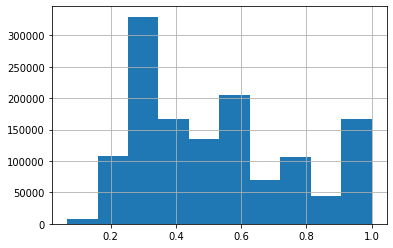

In [20]:
out.obs['celltype_fraction'].hist()

In [97]:
np.max(adata_sp.X)

ArrayView(131.)

<ipython-input-98-da1575d442cf>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sp.obs['celltype'] = out.obs['celltype']
/opt/conda/envs/atac_env/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


<AxesSubplot: >

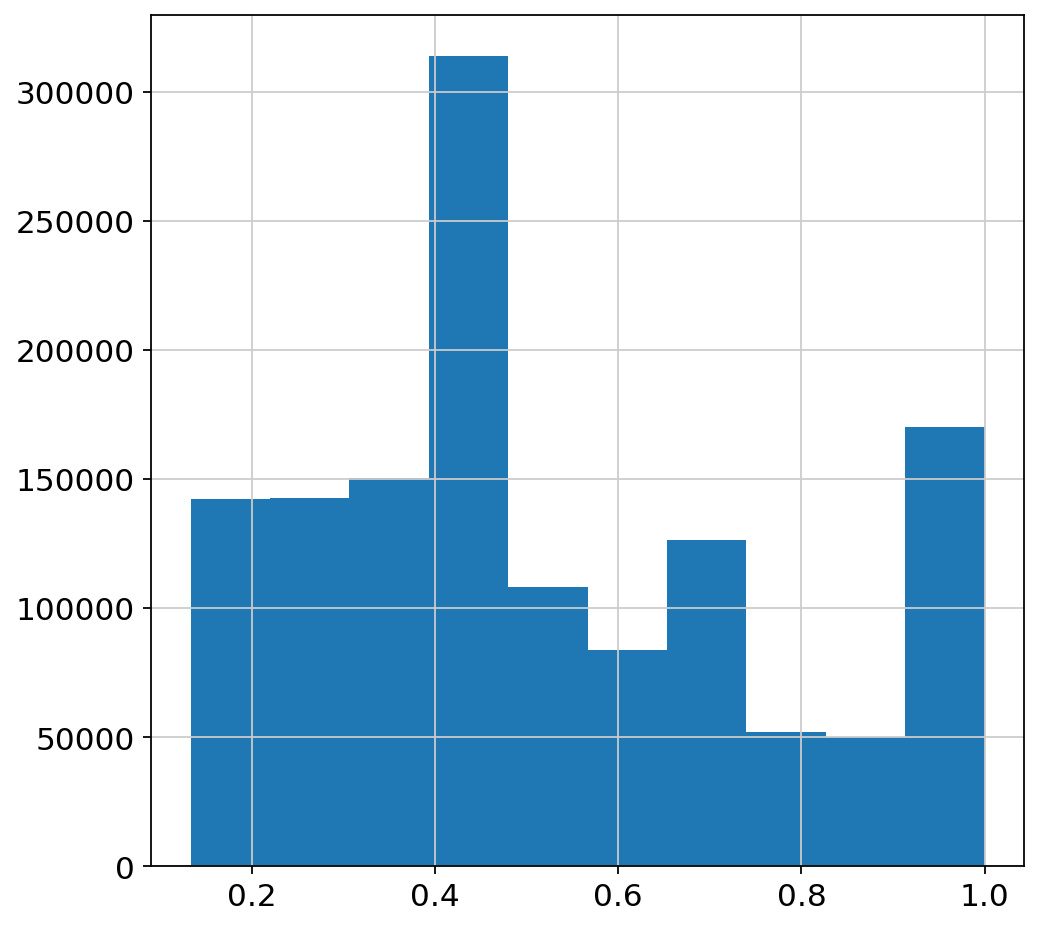

In [98]:
adata_sp.obs['celltype'] = out.obs['celltype']
adata_sp.obs['celltype_fraction'] = out.obs['celltype_fraction']
adata_sp.obs['celltype_fraction'].hist()

In [99]:
adata_sp = adata_sp[[i >= 0.8 for i in adata_sp.obs['celltype_fraction']]]

In [100]:
adata_sp.obs['celltype'].value_counts()

Endothelial                 38686
Uterus/Cervix Epi           31555
Fallopian Epi               18360
Lower Vagina SmMu           16342
Upper Vagina Mese           14944
Lower Vagina Epi            14370
Perivascular                13571
Schwann                     13245
Neural                      12010
Immune                      11494
Preputial Lamina Epi        11085
Upper Vagina Epi            10661
Fallopian SmMu               7405
Glans                        5916
Coelomic Epi                 5783
Corpus Cavernosum            5165
Fallopian Mese               4406
Cervix/Vagina Lig            3946
Cervix/Upper Vagina SmMu     3619
Bladder Mese                 3481
Endothelial Lymphatic        3094
Genital Surface Epi          3036
Epoophron Mese               2992
Mesonephric Tubules Epi      2694
Pre-Perivascular             2573
Uterus SmMu                  2571
Uterus Mese                  2385
Urethral Epi                 2249
Lower Vagina Mese            1040
Uterus Lig    

In [108]:
a = list(np.unique(adata_sp.obs['celltype']))
b = ['Coelomic Epi', 'Mesonephric Tubules Epi','Epoophron Mese', 
    'Fallopian Epi', 'Ciliated Epi', 'Fallopian Mese', 'Fallopian Lig',
    'Fallopian SmMu', 'Uterus/Cervix Epi','Uterus Mese', 'Uterus Lig', 'Uterus SmMu', 
    'Cervix Mese','Cervix/Upper Vagina SmMu', 'Cervix/Vagina Lig',
    'Upper Vagina Epi','Upper Vagina Mese',
    'Lower Vagina Epi',
    'Lower Vagina Mese',
     'Lower Vagina SmMu',  
    
    'Urethral Epi','Genital Surface Epi', 
    'Preputial Lamina Epi','Glans','Corpus Spongiosum',
    
    'Corpus Cavernosum', 'Prepuce',
    'Labia', 'Bladder Mese', 
    
    'Pre-Perivascular',
     'Perivascular', 'Skeletal Muscle',  'Endothelial', 'Endothelial Lymphatic',
    'Immune','Erythroid',  'Schwann','Neural']
[i for i in b if i not in a]

['Erythroid']

In [109]:
adata_sp.obs['celltype'] = adata_sp.obs['celltype'].astype('category')
adata_sp.obs['celltype'] = adata_sp.obs['celltype'].cat.reorder_categories(
    ['Coelomic Epi', 'Mesonephric Tubules Epi','Epoophron Mese', 
    'Fallopian Epi', 'Ciliated Epi', 'Fallopian Mese', 'Fallopian Lig',
    'Fallopian SmMu', 'Uterus/Cervix Epi','Uterus Mese', 'Uterus Lig', 'Uterus SmMu', 
    'Cervix Mese','Cervix/Upper Vagina SmMu', 'Cervix/Vagina Lig',
    'Upper Vagina Epi','Upper Vagina Mese',
    'Lower Vagina Epi',
    'Lower Vagina Mese',
     'Lower Vagina SmMu',  
    
    'Urethral Epi','Genital Surface Epi', 
    'Preputial Lamina Epi','Glans','Corpus Spongiosum',
    
    'Corpus Cavernosum', 'Prepuce',
    'Labia', 'Bladder Mese', 
    
    'Pre-Perivascular',
     'Perivascular', 'Skeletal Muscle',  'Endothelial', 'Endothelial Lymphatic',
    'Immune','Schwann','Neural'])

In [110]:
sc.pp.normalize_total(adata_sp)
sc.pp.log1p(adata_sp)
sc.pp.scale(adata_sp, max_value=10)

In [111]:
np.max(adata_sp.X)

10.0

In [163]:
markers = ['EMX2', 'PAX8', 'WNT4', 'WNT5A',
           'LRRN4', 'CTHRC1', 'PLAC1', 'C7', 'SOX17', 'PART1', 'CDH2', 'DNAH12', 'DNAI1', 'ITGBL1', 'TSPAN8',
          
           'MYH11', 'FBXL22', 
          'WNT7A', 'LGR5', 'UCA1', 'DLX5',  'ITGA4', 
           'PTGER3', 'RORB', 'HS3ST3A1', 
           'PRDM8',   'KRT5', 'SRD5A2', 'CRYM', 
           'HOXB13', 'CPA6', 'FOXF1', 'GATA3', 'SNX31', 'SPINK1', 'IRX2', 'KRT14','WIF1', 'FOXF2', 'GAP43', 'AR',  'SOX9', 
           'MME', 'DKK1', 'FOXS1',
          'RGS5',
           'CDH5', 'PLVAP', 'LYVE1', 'TFF3', 'CD68', 'MPZ', 'PLP1', 'STMN2']

In [164]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                         frameon=True, vector_friendly=True, fontsize=14, figsize=[7,7], color_map=None, 
                         format='pdf', facecolor=None, transparent=False,)

In [165]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


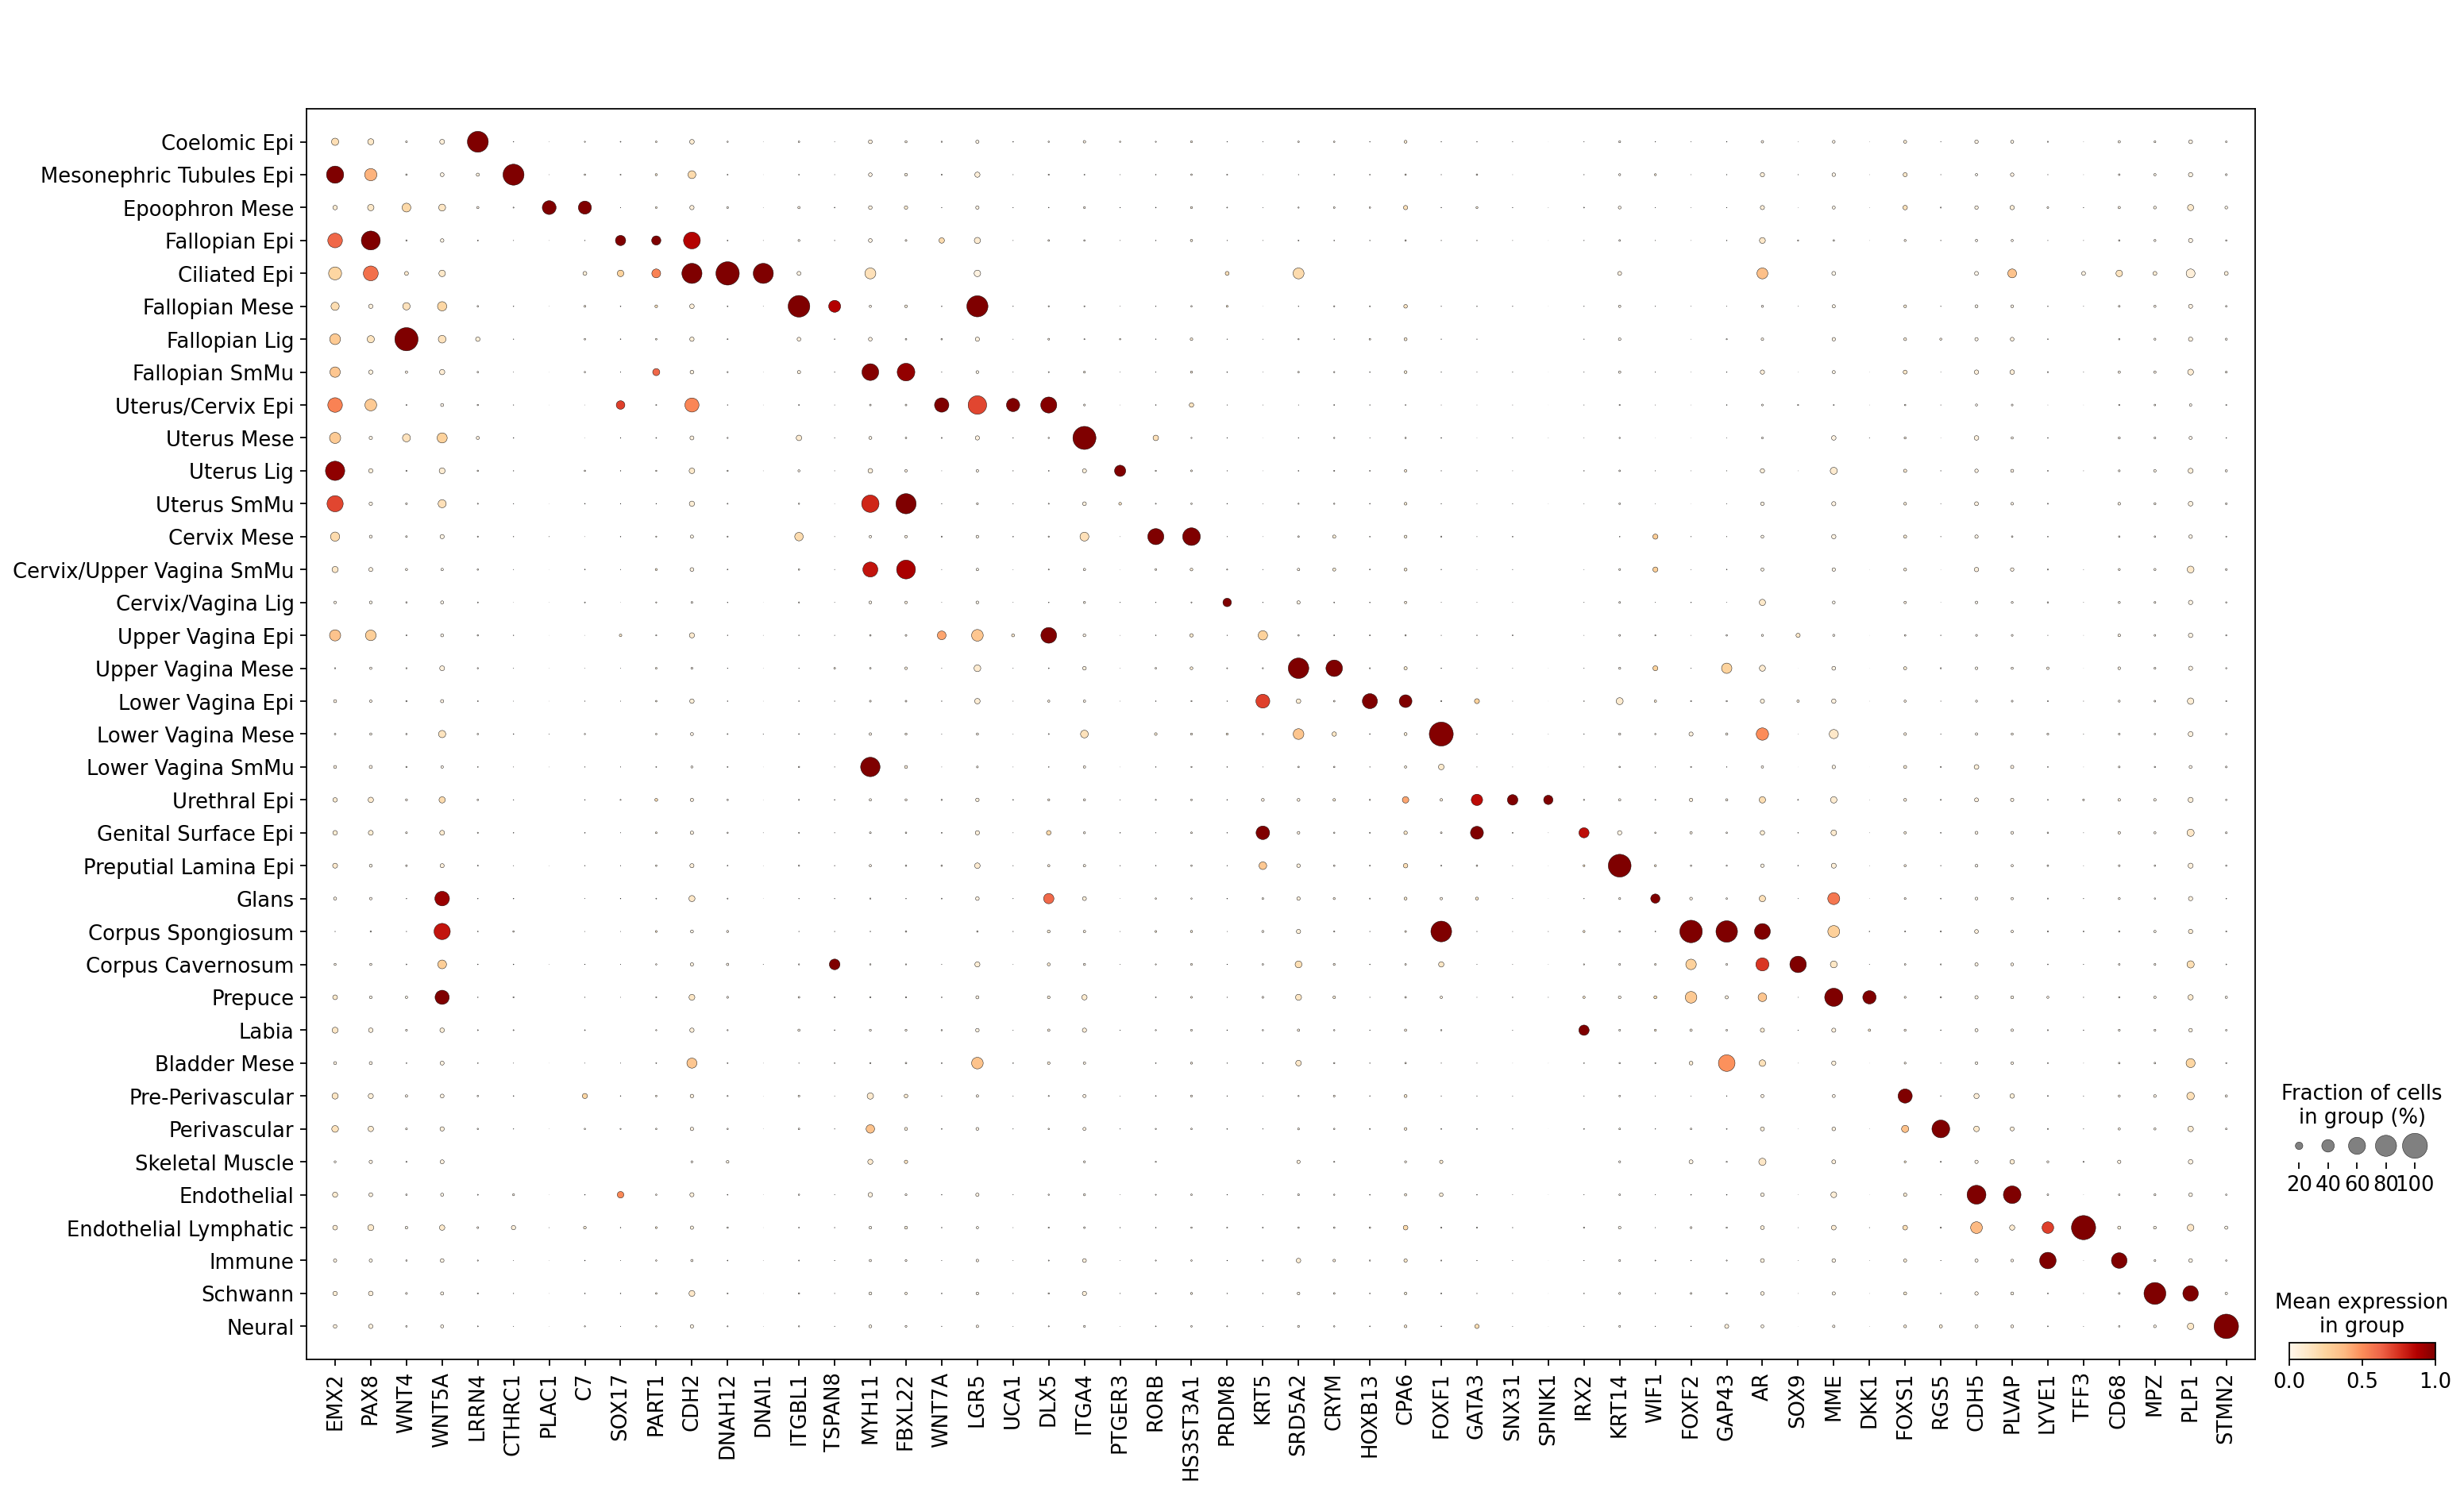

In [166]:
sc.pl.dotplot(adata_sp, var_names = markers, 
              groupby = 'celltype', standard_scale = 'var', color_map = 'OrRd', 
             save = 'iss_specificity_markers_dotplot_>10pcw_female')

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/envs/atac_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
<ipython-input-31-2b73c7e74e41>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_data['celltype'] = pd.Categorical(confidence_data['celltype'], categories=cell_types, ordered=True)


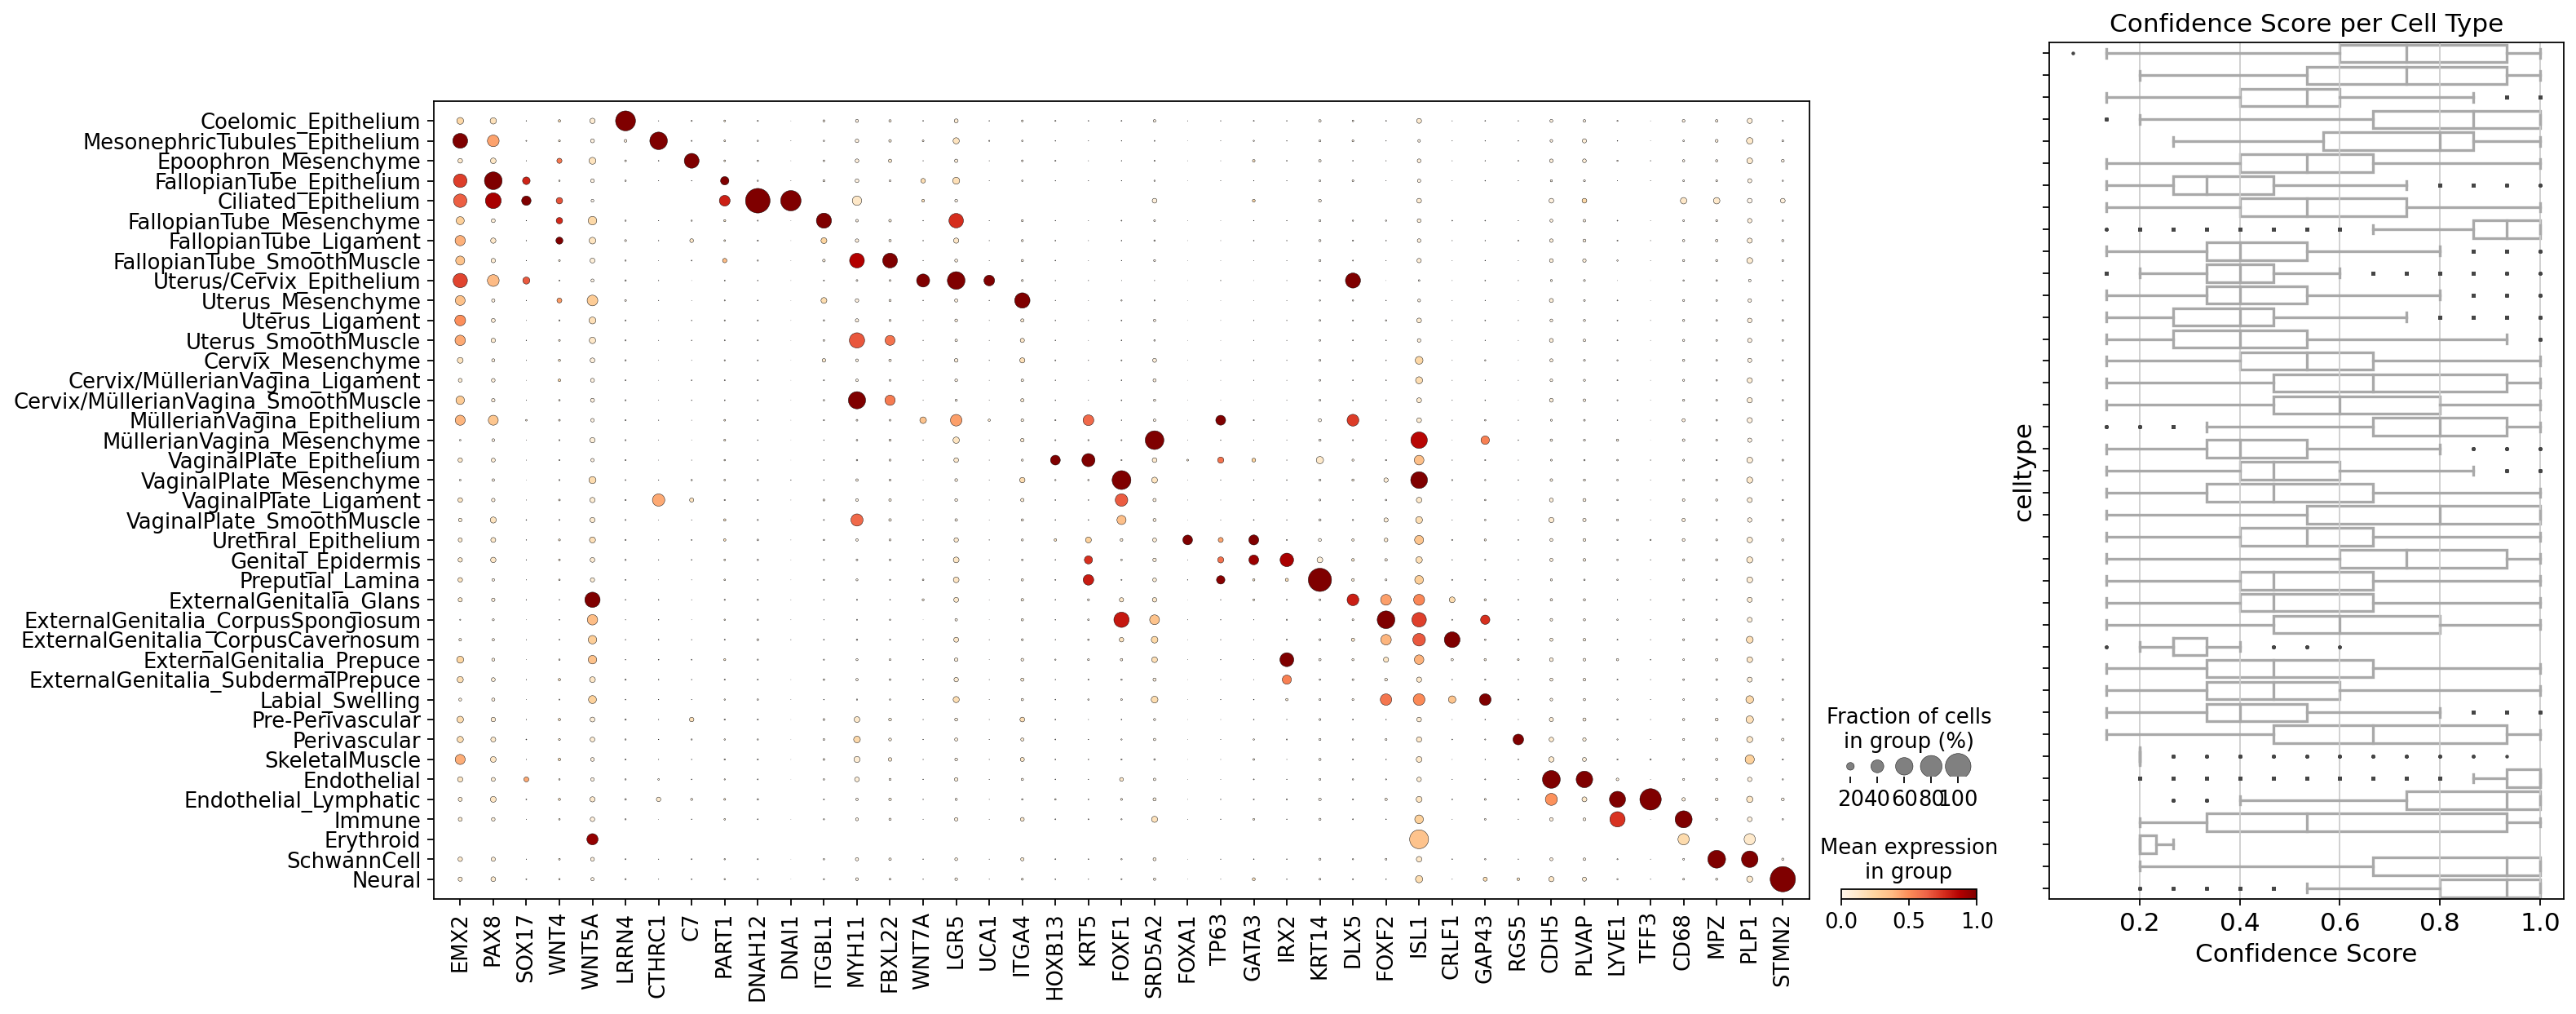

In [31]:
# Create a new figure for the combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

# Create a dotplot for gene expression, with cell types on the y-axis and draw it on the specified axis
# Extract the cell types from the dotplot for ordering
cell_types = adata_sp.obs['celltype'].unique()
sc.pl.dotplot(adata_sp, var_names = markers, 
              groupby = 'celltype', standard_scale = 'var', color_map = 'OrRd', ax=ax1, show=False)

# Now we will create the boxplot on the y-axis corresponding to cell types
confidence_data = adata_sp.obs[['celltype', 'celltype_fraction']]  # Assuming 'confidence_score' is in obs

# To align the boxplot vertically, we need to sort by cell_type
confidence_data['celltype'] = pd.Categorical(confidence_data['celltype'], categories=cell_types, ordered=True)

# Customizations for empty boxplot with grey contours and smaller outliers
boxprops = {'facecolor': 'none', 'edgecolor': 'darkgrey'}  # Empty box with grey edge
whiskerprops = {'color': 'darkgrey'}
capprops = {'color': 'darkgrey'}
medianprops = {'color': 'darkgrey'}
flierprops = {'marker': 'o', 'color': 'grey', 'markersize': 1}  # Smaller grey outliers

# Plot the boxplot with horizontal orientation to match the y-axis
sns.boxplot(y='celltype', x='celltype_fraction', data=confidence_data, ax=ax2, orient='h',
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
            medianprops=medianprops, flierprops=flierprops)

# Adjust the title and layout
ax2.set_title('Confidence Score per Cell Type')
ax2.set_xlabel('Confidence Score')

# Make sure both plots align properly
plt.tight_layout()

# Save the figure as a PDF, ensuring both plots are saved
plt.savefig("iss_dotplot_boxplot>=10pcw_female.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

## Evaluate cell type proportions per annotated anatomical structure 

In [28]:
out2 = out[[i >= 0.8 for i in out.obs['celltype_fraction']]]

In [29]:
out2.obs['celltype'].value_counts()

Endothelial                 38686
Uterus/Cervix Epi           31555
Fallopian Epi               18360
Lower Vagina SmMu           16342
Upper Vagina Mese           14944
Lower Vagina Epi            14370
Perivascular                13571
Schwann                     13245
Neural                      12010
Immune                      11494
Preputial Lamina Epi        11085
Upper Vagina Epi            10661
Fallopian SmMu               7405
Glans                        5916
Coelomic Epi                 5783
Corpus Cavernosum            5165
Fallopian Mese               4406
Cervix/Vagina Lig            3946
Cervix/Upper Vagina SmMu     3619
Bladder Mese                 3481
Endothelial Lymphatic        3094
Genital Surface Epi          3036
Epoophron Mese               2992
Mesonephric Tubules Epi      2694
Pre-Perivascular             2573
Uterus SmMu                  2571
Uterus Mese                  2385
Urethral Epi                 2249
Lower Vagina Mese            1040
Uterus Lig    

In [30]:
df_subset = out2.obs[['celltype', 'broad_anatomy']]

In [31]:
df_subset['broad_anatomy'].value_counts()

Cervix                   64606
FallopianTube            52123
UpperVagina              49359
Uterus                   41949
VaginalPlate             32258
External Genitalia       15948
Epoophron                 9127
LabioScrotal Swelling     3752
LowerTract                3317
Name: broad_anatomy, dtype: int64

In [34]:
df_subset['broad_anatomy'] = np.where(df_subset['broad_anatomy'] == 'LabioScrotal Swelling', 'External Genitalia', df_subset['broad_anatomy'])

<ipython-input-34-23311bb4cfda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['broad_anatomy'] = np.where(df_subset['broad_anatomy'] == 'LabioScrotal Swelling', 'External Genitalia', df_subset['broad_anatomy'])


In [35]:
df_subset['broad_anatomy'] = np.where(df_subset['broad_anatomy'] == 'LowerTract', 'External Genitalia', df_subset['broad_anatomy'])

<ipython-input-35-b061f2602b19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['broad_anatomy'] = np.where(df_subset['broad_anatomy'] == 'LowerTract', 'External Genitalia', df_subset['broad_anatomy'])


In [36]:
df_subset['broad_anatomy'].value_counts()

Cervix                63058
FallopianTube         50022
UpperVagina           48543
Uterus                41287
VaginalPlate          31837
External Genitalia    23350
Epoophron              9242
Name: broad_anatomy, dtype: int64

In [32]:
for s in [CM008, CM013, CM015, CM016, CM018]: 
    s.obs['celltype'] = s.obs_names.map(out.obs['celltype'].to_dict())
    s.obs['celltype'] = s.obs['celltype'].astype('str')
    s.obs['celltype_fraction'] = s.obs_names.map(out.obs['celltype_fraction'].to_dict())

## CM013

In [33]:
CM013.obs['celltype'].value_counts()

Cervix/Vagina Lig           85914
Uterus Lig                  44243
Cervix/Upper Vagina SmMu    42797
Upper Vagina Mese           40623
Pre-Perivascular            36517
Fallopian Lig               31179
Skeletal Muscle             30131
Uterus Mese                 27521
Endothelial                 27357
Uterus SmMu                 26791
Bladder Mese                24133
Cervix Mese                 23287
nan                         22753
Fallopian SmMu              21727
Lower Vagina SmMu           21502
Uterus/Cervix Epi           20480
Epoophron Mese              19614
Fallopian Mese              18061
Lower Vagina Epi            17879
Perivascular                15137
Glans                       14384
Upper Vagina Epi            13280
Fallopian Epi               13169
Lower Vagina Mese           12066
Schwann                     11901
Preputial Lamina Epi        11430
Immune                      11144
Labia                        7985
Coelomic Epi                 7360
Neural        

In [ ]:
for i in np.unique(CM013.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM013,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [35]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                         frameon=True, vector_friendly=True, fontsize=14, figsize=[7,7], color_map=None, 
                         format='pdf', facecolor=None, transparent=False,)

In [36]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [37]:
np.unique(CM013.obs['celltype'])

array(['Bladder Mese', 'Cervix Mese', 'Cervix/Upper Vagina SmMu',
       'Cervix/Vagina Lig', 'Ciliated Epi', 'Coelomic Epi',
       'Corpus Cavernosum', 'Corpus Spongiosum', 'Endothelial',
       'Endothelial Lymphatic', 'Epoophron Mese', 'Erythroid',
       'Fallopian Epi', 'Fallopian Lig', 'Fallopian Mese',
       'Fallopian SmMu', 'Genital Surface Epi', 'Glans', 'Immune',
       'Labia', 'Lower Vagina Epi', 'Lower Vagina Mese',
       'Lower Vagina SmMu', 'Mesonephric Tubules Epi', 'Neural',
       'Perivascular', 'Pre-Perivascular', 'Prepuce',
       'Preputial Lamina Epi', 'Schwann', 'Skeletal Muscle',
       'Upper Vagina Epi', 'Upper Vagina Mese', 'Urethral Epi',
       'Uterus Lig', 'Uterus Mese', 'Uterus SmMu', 'Uterus/Cervix Epi',
       'nan'], dtype=object)

In [38]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Mesonephric Tubules Epi',
                            'Fallopian Epi',
                            'Uterus/Cervix Epi',
                            'Upper Vagina Epi',
                            'Lower Vagina Epi',
      
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM013.obs['ducts'] = CM013.obs.apply(new_column, axis=1)


In [39]:
CM013.obs['ducts'].value_counts(dropna=False)

NaN                        687773
Uterus/Cervix Epi           15424
Lower Vagina Epi            10704
Fallopian Epi                8806
Upper Vagina Epi             5813
Mesonephric Tubules Epi      1344
Name: ducts, dtype: int64

In [40]:
CM013.obs['ducts'] = CM013.obs['ducts'].astype(str)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


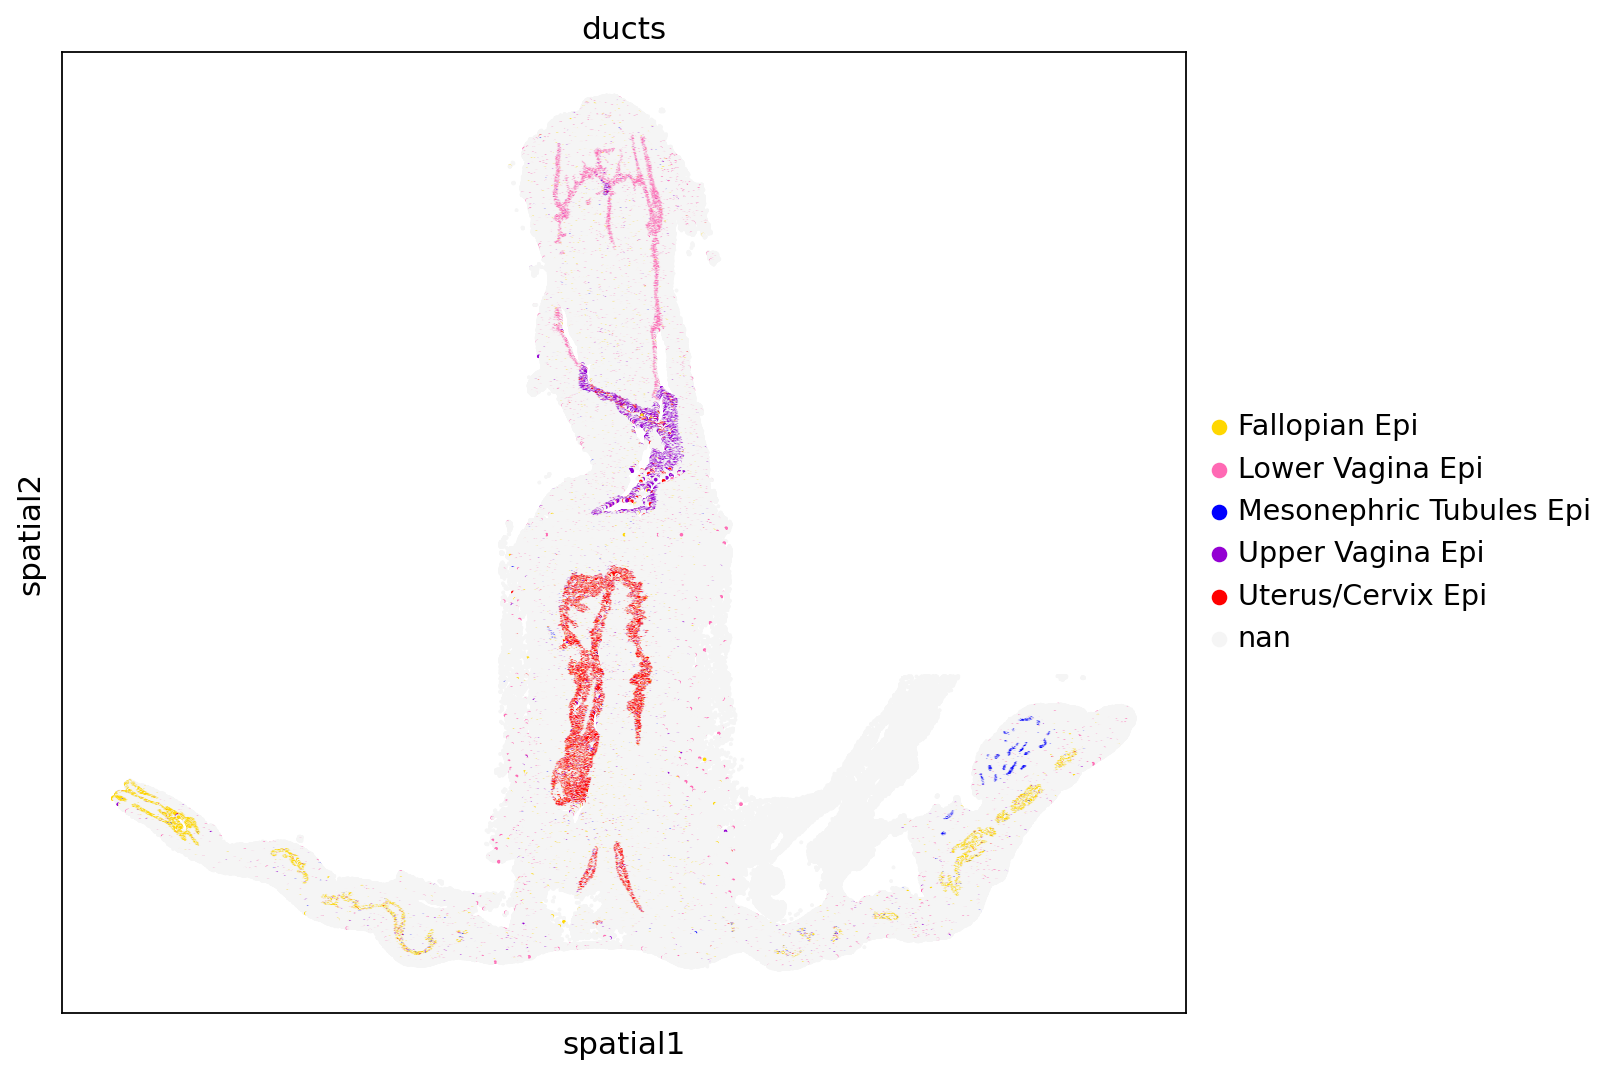

In [42]:
sq.pl.spatial_scatter(
    CM013,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#     legend_loc = 'right margin',
#                     palette= {'Fallopian Epi' : 'gold',  
#                               'Uterus/Cervix Epi' : 'red', 
#                               'Mesonephric Tubules Epi' : 'blue',
#                               'Upper Vagina Epi' : 'darkviolet', 
#                               'Lower Vagina Epi': 'hotpink',
          
#        'nan' : 'whitesmoke'
#                              },
    save = 'CM013_ducts_filtered.pdf'
)

In [43]:
np.unique(CM013.obs['celltype'])

array(['Bladder Mese', 'Cervix Mese', 'Cervix/Upper Vagina SmMu',
       'Cervix/Vagina Lig', 'Ciliated Epi', 'Coelomic Epi',
       'Corpus Cavernosum', 'Corpus Spongiosum', 'Endothelial',
       'Endothelial Lymphatic', 'Epoophron Mese', 'Erythroid',
       'Fallopian Epi', 'Fallopian Lig', 'Fallopian Mese',
       'Fallopian SmMu', 'Genital Surface Epi', 'Glans', 'Immune',
       'Labia', 'Lower Vagina Epi', 'Lower Vagina Mese',
       'Lower Vagina SmMu', 'Mesonephric Tubules Epi', 'Neural',
       'Perivascular', 'Pre-Perivascular', 'Prepuce',
       'Preputial Lamina Epi', 'Schwann', 'Skeletal Muscle',
       'Upper Vagina Epi', 'Upper Vagina Mese', 'Urethral Epi',
       'Uterus Lig', 'Uterus Mese', 'Uterus SmMu', 'Uterus/Cervix Epi',
       'nan'], dtype=object)

In [44]:
CM013.obs['broad_anatomy'].value_counts()

Cervix           192405
FallopianTube    136409
UpperVagina      135377
Uterus           115565
VaginalPlate     104337
Epoophron         23018
Unassigned        22753
Name: broad_anatomy, dtype: int64

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


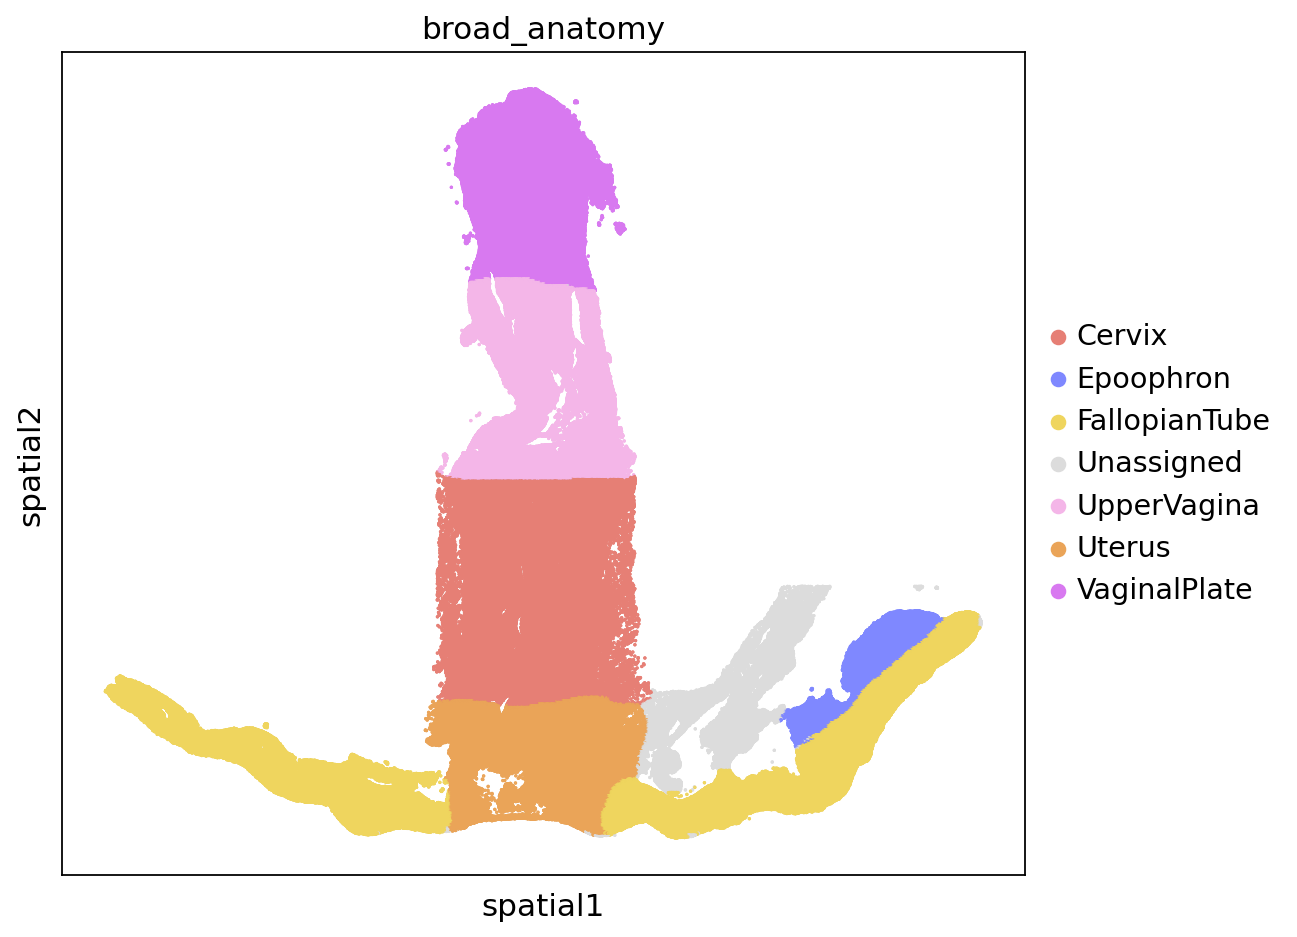

In [39]:
sq.pl.spatial_scatter(
    CM013,
    spatial_key="spatial",
    color=['broad_anatomy'],
    shape=None,
    use_raw = False,
    size=1,
    cmap = 'jet',
    figsize=(8,8), 
           legend_loc = 'right margin',
#                              palette= {'FallopianTube' : '#efd55e',  
                                                                                   
#                                        'Uterus' : '#eaa458', 
#                                        'Cervix' : '#e67f75', 
#                                        'UpperVagina' : '#f4b6e8',
#                                        'VaginalPlate' : '#d879f0', 
#                                        'Epoophron' : '#7f88ff',
                                       
#                 'Unassigned' : 'gainsboro', 'Background' : 'gainsboro',
#                                       },
    save = 'CM013_ducts_anatomy.pdf'
)

In [85]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Fallopian Mese',
                            'Uterus Mese',
                            'Cervix Mese',
                            'Upper Vagina Mese',
                            'Lower Vagina Mese',
      
                            
                             ]) and (row['celltype_fraction'] > 0.5):
        return row['celltype']
    else:
        return np.nan

CM013.obs['mese'] = CM013.obs.apply(new_column, axis=1)

In [86]:
CM013.obs['mese'] = CM013.obs['mese'].astype(str)

In [87]:
CM013.obs['mese'].value_counts()

nan                  680264
Upper Vagina Mese     26509
Uterus Mese            8110
Fallopian Mese         7453
Cervix Mese            3764
Lower Vagina Mese      3764
Name: mese, dtype: int64

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


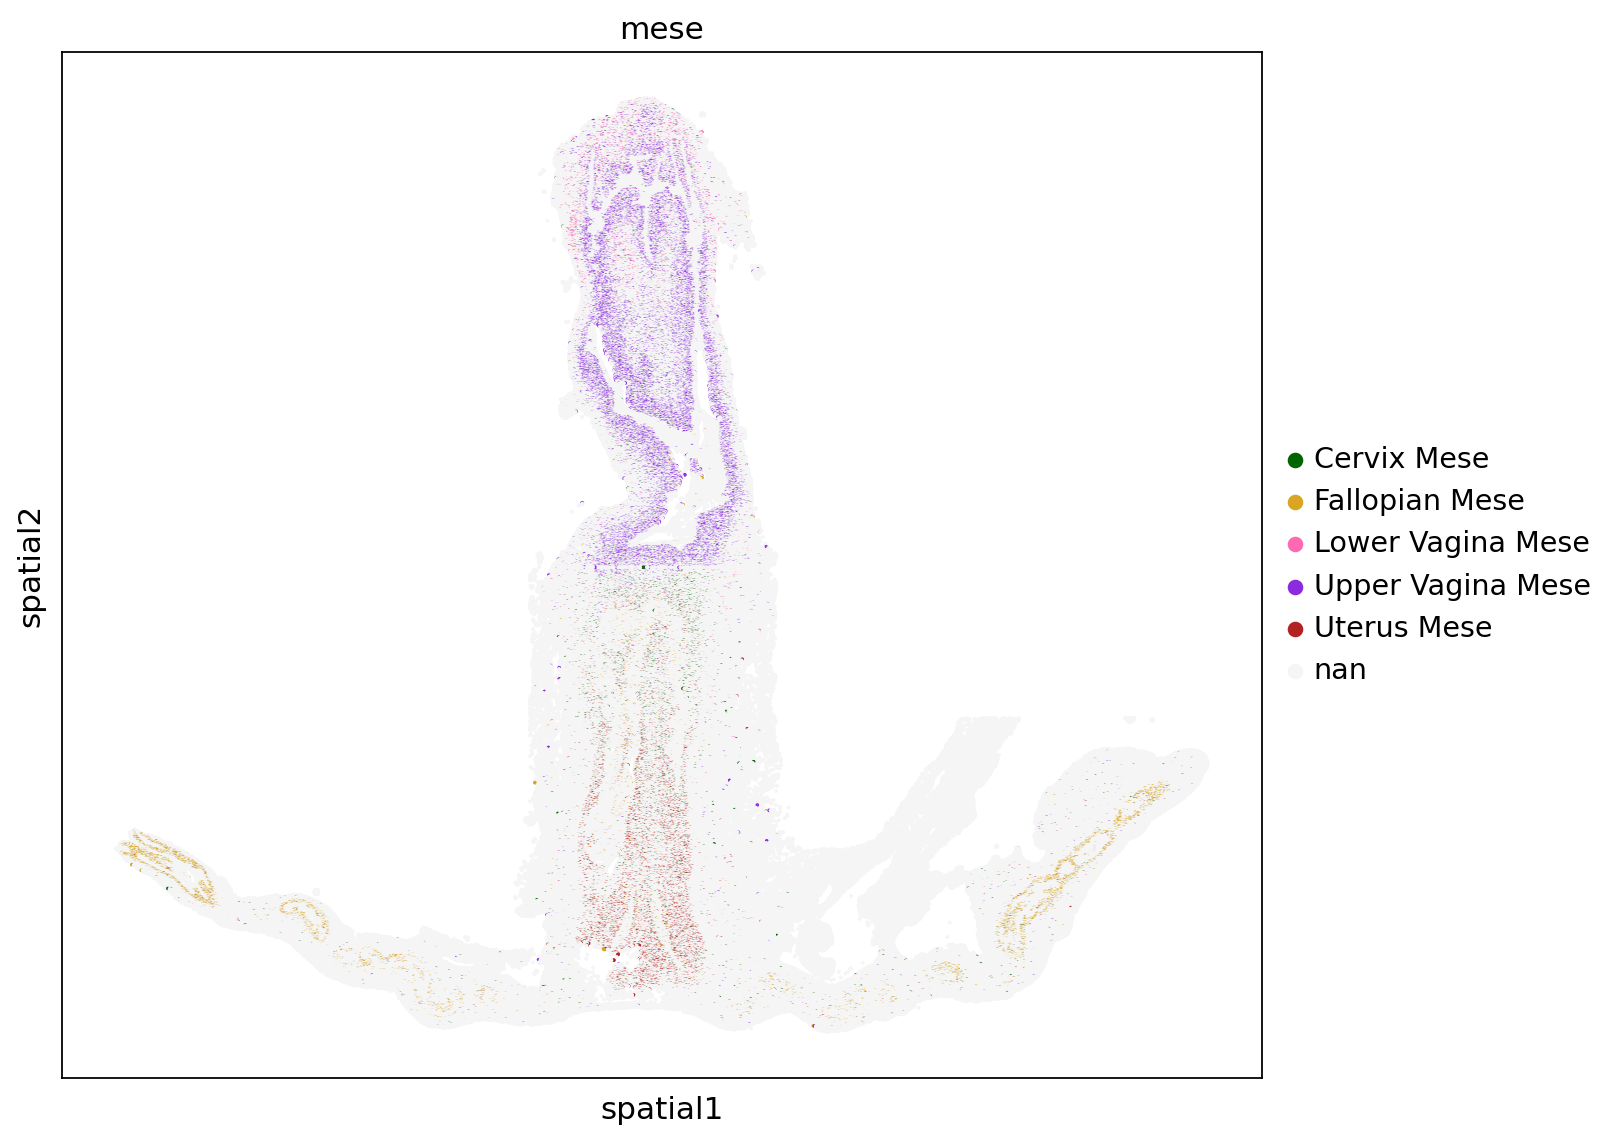

In [89]:
sq.pl.spatial_scatter(
    CM013,
    spatial_key="spatial",
    color=['mese'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#     palette = {'Cervix Mese' : 'darkgreen', 'Fallopian Mese' : 'goldenrod', 
#               'Lower Vagina Mese' : 'hotpink', 'Upper Vagina Mese' : 'blueviolet', 'Uterus Mese' : 'firebrick', 
#               'nan' : 'whitesmoke'},
    save = 'CM013_mese_filtered.pdf'
)

## CM008

In [ ]:
for i in np.unique(CM008.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM008,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [51]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in [
                            'Uterus/Cervix Epi',
                            'Upper Vagina Epi',
                            'Lower Vagina Epi',
      
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM008.obs['ducts'] = CM008.obs.apply(new_column, axis=1)

In [52]:
CM008.obs['ducts'] = CM008.obs['ducts'].astype(str)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


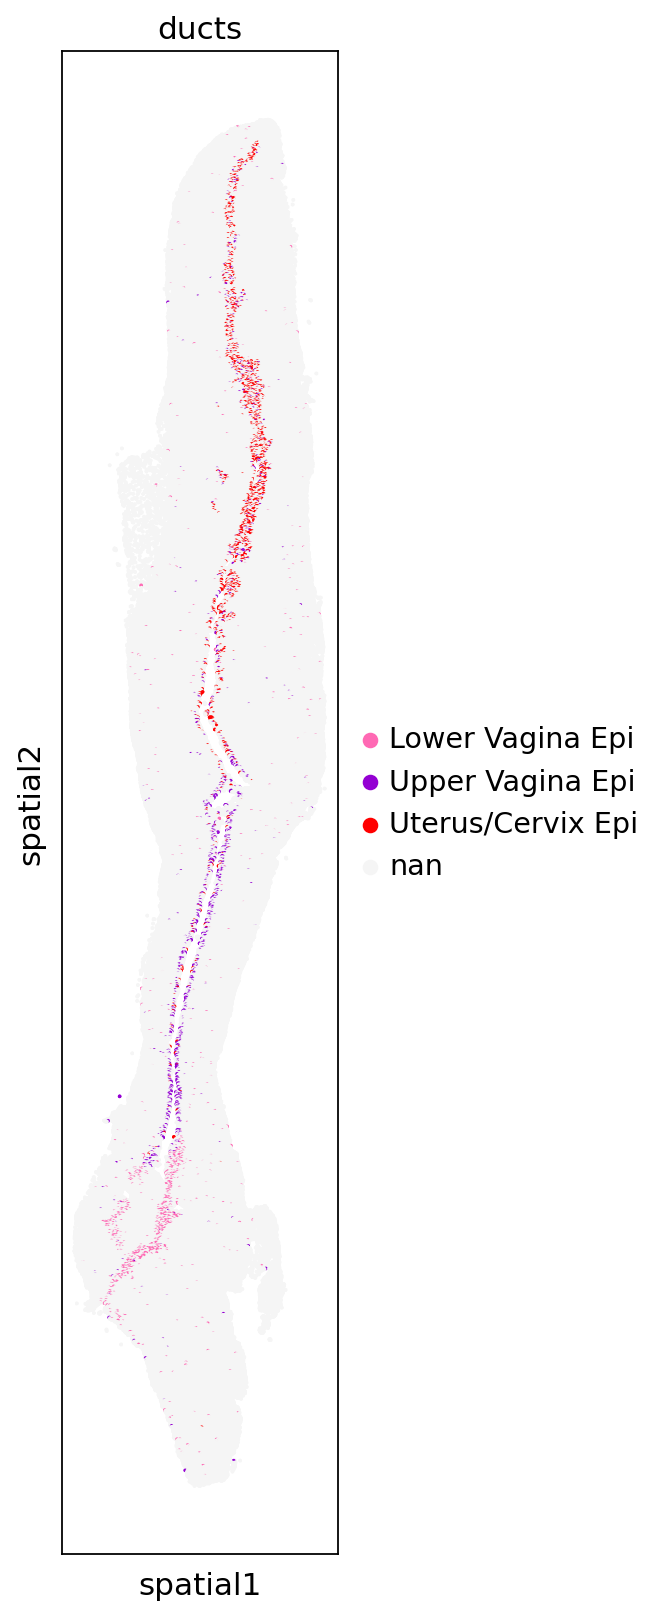

In [54]:
sq.pl.spatial_scatter(
    CM008,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#     legend_loc = 'right margin',
#                     palette= {
#                               'Uterus/Cervix Epi' : 'red', 
#                               'Upper Vagina Epi' : 'darkviolet', 
#                               'Lower Vagina Epi': 'hotpink',
#        'nan' : 'whitesmoke'
#                              },
    save = 'CM008_ducts_filtered.pdf'
)

In [55]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in [
                            'Uterus Mese',
                            'Cervix Mese',
                            'Upper Vagina Mese',
                            'Lower Vagina Mese',
      
                            
                             ]) and (row['celltype_fraction'] > 0.6):
        return row['celltype']
    else:
        return np.nan

CM008.obs['mese'] = CM008.obs.apply(new_column, axis=1)

In [56]:
CM008.obs['mese'] = CM008.obs['mese'].astype(str)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


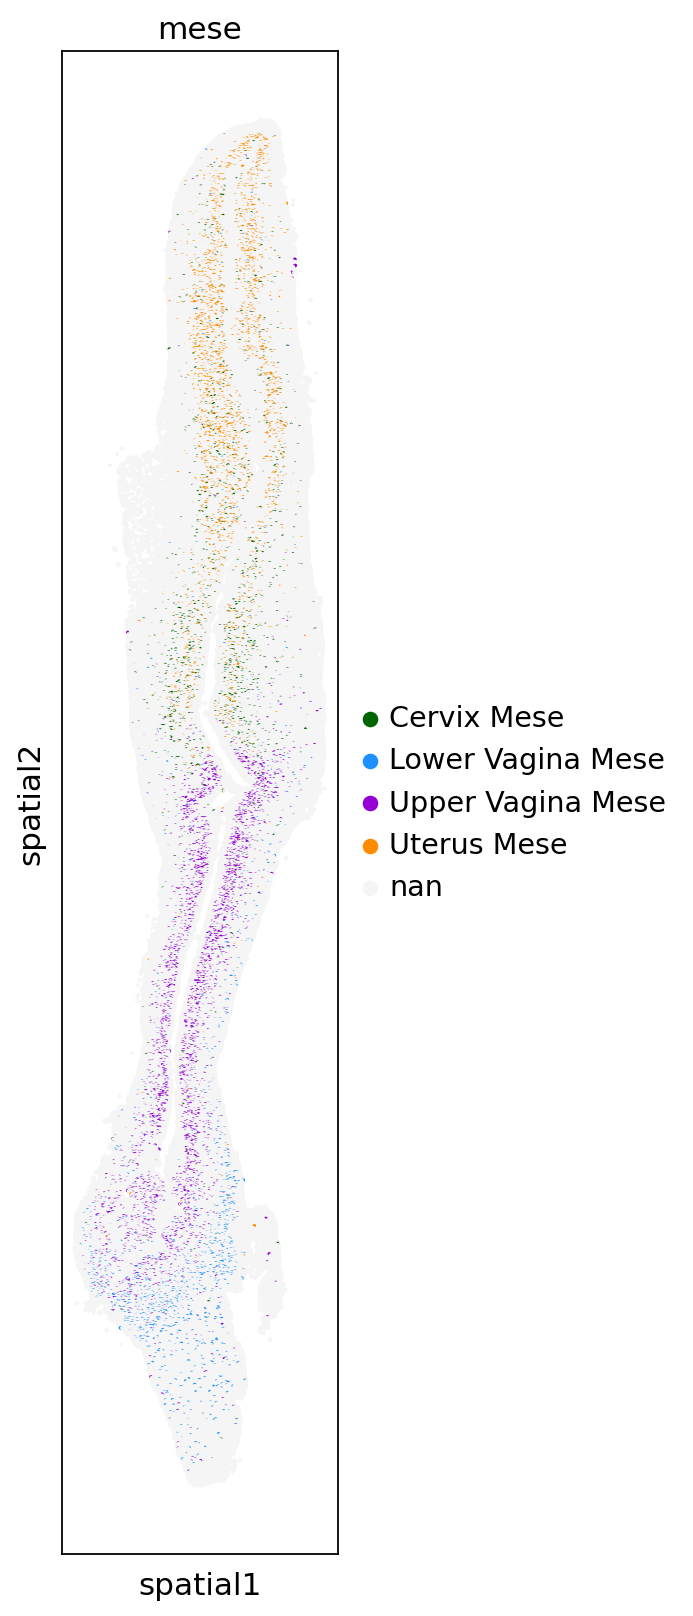

In [67]:
sq.pl.spatial_scatter(
    CM008,
    spatial_key="spatial",
    color=['mese'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#      legend_loc = 'right margin',
#                      palette= {
#                                'Uterus Mese' : 'darkorange', 
#                                 'Cervix Mese' : 'darkgreen',
#                                'Upper Vagina Mese' : 'darkviolet', 
#                                'Lower Vagina Mese': 'dodgerblue',
#         'nan' : 'whitesmoke'
#                               },
    save = 'CM008_mese_filtered.pdf'
)

## CM015

In [ ]:
for i in np.unique(CM015.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM015,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [59]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in [
                            'Uterus/Cervix Epi',
                            'Fallopian Epi', 
                            'Mesonephric Tubules Epi', 
      
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM015.obs['ducts'] = CM015.obs.apply(new_column, axis=1)

In [60]:
CM015.obs['ducts'] = CM015.obs['ducts'].astype(str)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


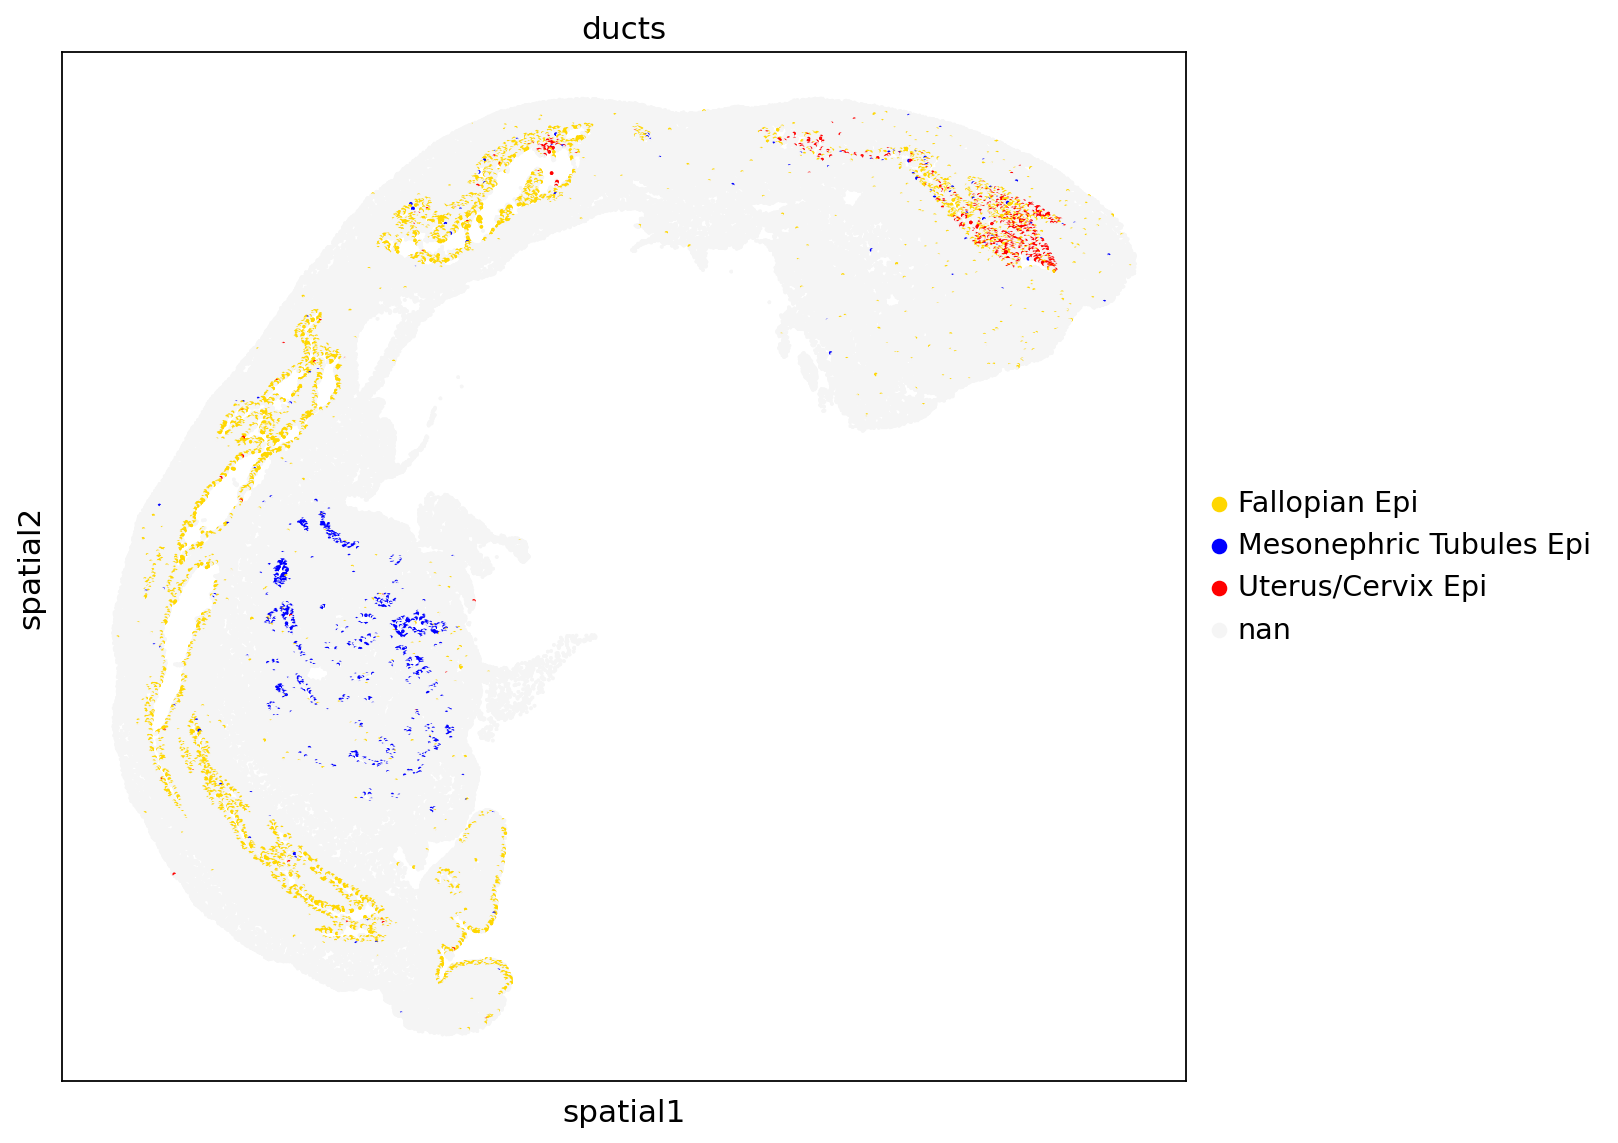

In [68]:
sq.pl.spatial_scatter(
    CM015,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#     legend_loc = 'right margin',
#                     palette= {'Fallopian Epi' : 'gold',  
#                               'Uterus/Cervix Epi' : 'red', 
#                               'Mesonephric Tubules Epi' : 'blue',

          
#        'nan' : 'whitesmoke'
#                              },
    save = 'CM015_ducts_filtered.pdf'
)

In [69]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in [
                            'Uterus Mese',
                            'Fallopian Mese', 
                            'Uterus/Cervix Epi',
                            'Fallopian Epi', 
                            'Mesonephric Tubules Epi'
      
                             ]) and (row['celltype_fraction'] > 0.6):
        return row['celltype']
    else:
        return np.nan

CM015.obs['mese'] = CM015.obs.apply(new_column, axis=1)

In [70]:
CM015.obs['mese'] = CM015.obs['mese'].astype(str)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


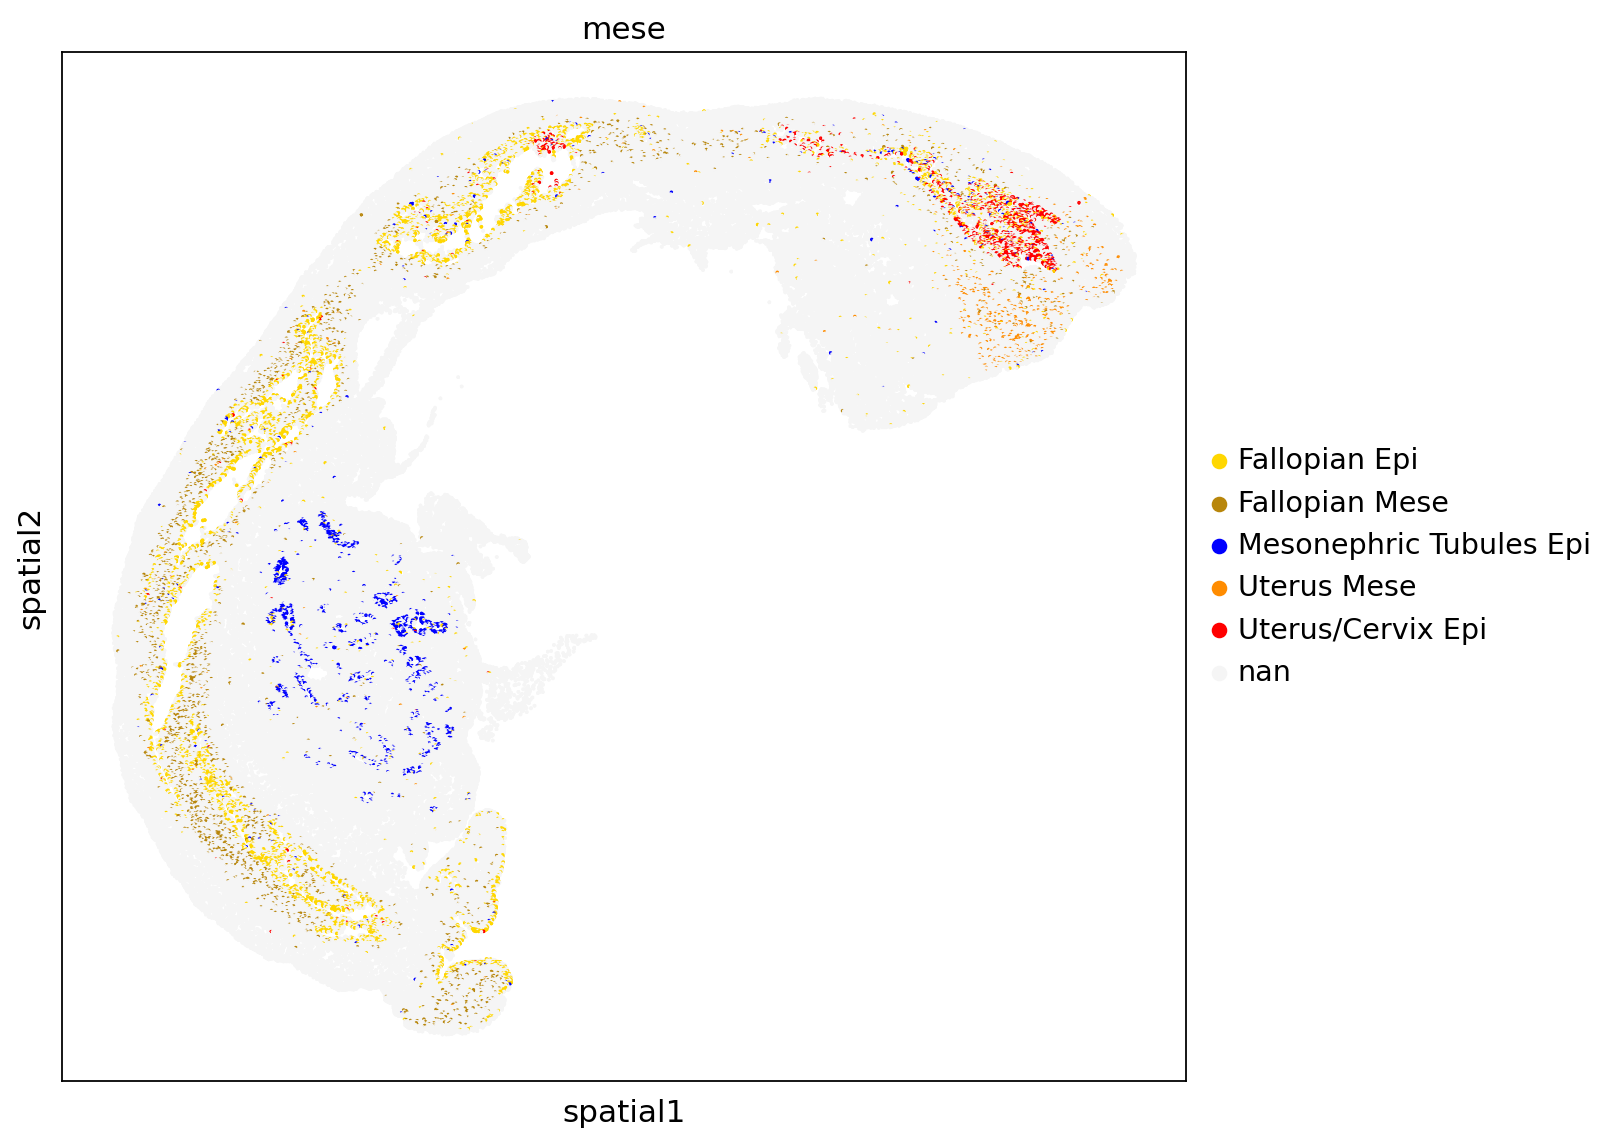

In [131]:
sq.pl.spatial_scatter(
    CM015,
    spatial_key="spatial",
    color=['mese'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#     legend_loc = 'right margin',
#                     palette= {'Fallopian Mese' : 'darkgoldenrod',  
#                               'Uterus Mese' : 'darkorange', 
#                                'Fallopian Epi' : 'gold',  
#                               'Uterus/Cervix Epi' : 'red', 
#                               'Mesonephric Tubules Epi' : 'blue',

          
#        'nan' : 'whitesmoke'
#                              },
    save = 'CM015_mese_filtered.pdf'
)

## CM016

In [71]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Mesonephric Tubules Epi',
                            'Fallopian Epi',
                            'Uterus/Cervix Epi',
                            'Upper Vagina Epi', 'Lower Vagina Epi'     
                            
                             ]) and (row['celltype_fraction'] > 0.8):
        return row['celltype']
    else:
        return np.nan

CM016.obs['ducts'] = CM016.obs.apply(new_column, axis=1)


In [72]:
CM016.obs['ducts'] = CM016.obs['ducts'].astype(str)

In [73]:
CM016.obs['ducts'].value_counts()

nan                        228501
Uterus/Cervix Epi           13995
Fallopian Epi                4627
Upper Vagina Epi             3364
Lower Vagina Epi             1245
Mesonephric Tubules Epi       401
Name: ducts, dtype: int64

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


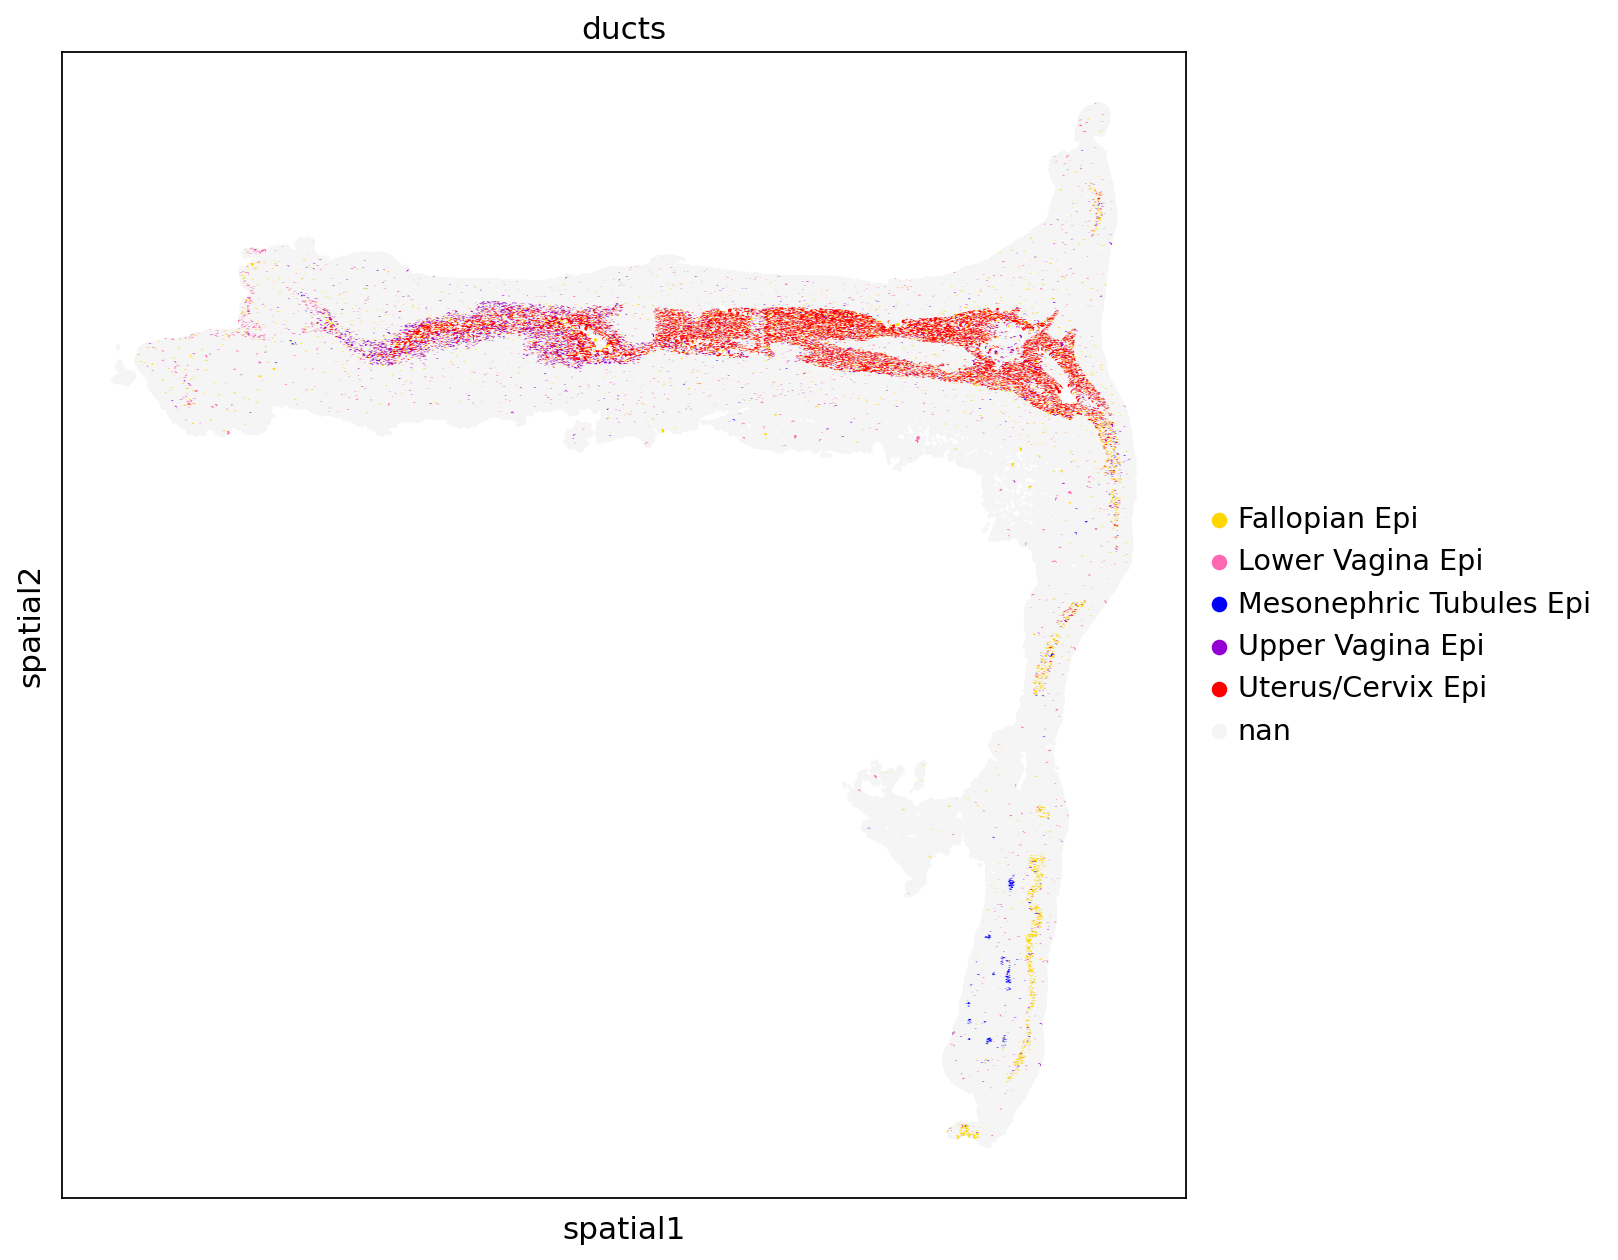

In [75]:
sq.pl.spatial_scatter(
    CM016,
    spatial_key="spatial",
    color=['ducts'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#     legend_loc = 'right margin',
#                     palette= {'Fallopian Epi' : 'gold',  
#                               'Uterus/Cervix Epi' : 'red', 
#                               'Mesonephric Tubules Epi' : 'blue',
#                               'Upper Vagina Epi' : 'darkviolet',  'Lower Vagina Epi' : 'hotpink',         
#        'nan' : 'whitesmoke'
#                              },
    save = 'CM016_ducts_filtered.pdf'
)

## CM018

In [ ]:
for i in np.unique(CM018.obs['celltype']):
    print(i)
    sq.pl.spatial_scatter(
    CM018,
    spatial_key="spatial",
    color=['celltype'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(8,8), 
    legend_loc = 'right margin',
    palette = 'Dark2',
    groups = i
    )

In [78]:
# Create a new column based on conditions
def new_column(row):
    if (row['celltype'] in ['Corpus Spongiosum',
                            'Corpus Cavernosum', 
                            'Glans',       
                            'Urethral Epi', 
                            'Genital Surface Epi',
                            
                             ]) and (row['celltype_fraction'] > 0.6):
        return row['celltype']
    else:
        return np.nan

CM018.obs['urethra_cs'] = CM018.obs.apply(new_column, axis=1)


In [79]:
CM018.obs['urethra_cs'].value_counts(dropna=False)

NaN                    86761
Corpus Cavernosum       6810
Glans                   4901
Corpus Spongiosum       2539
Genital Surface Epi     1449
Urethral Epi             805
Name: urethra_cs, dtype: int64

In [80]:
CM018.obs['urethra_cs'] = CM018.obs['urethra_cs'].astype(str)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:953: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


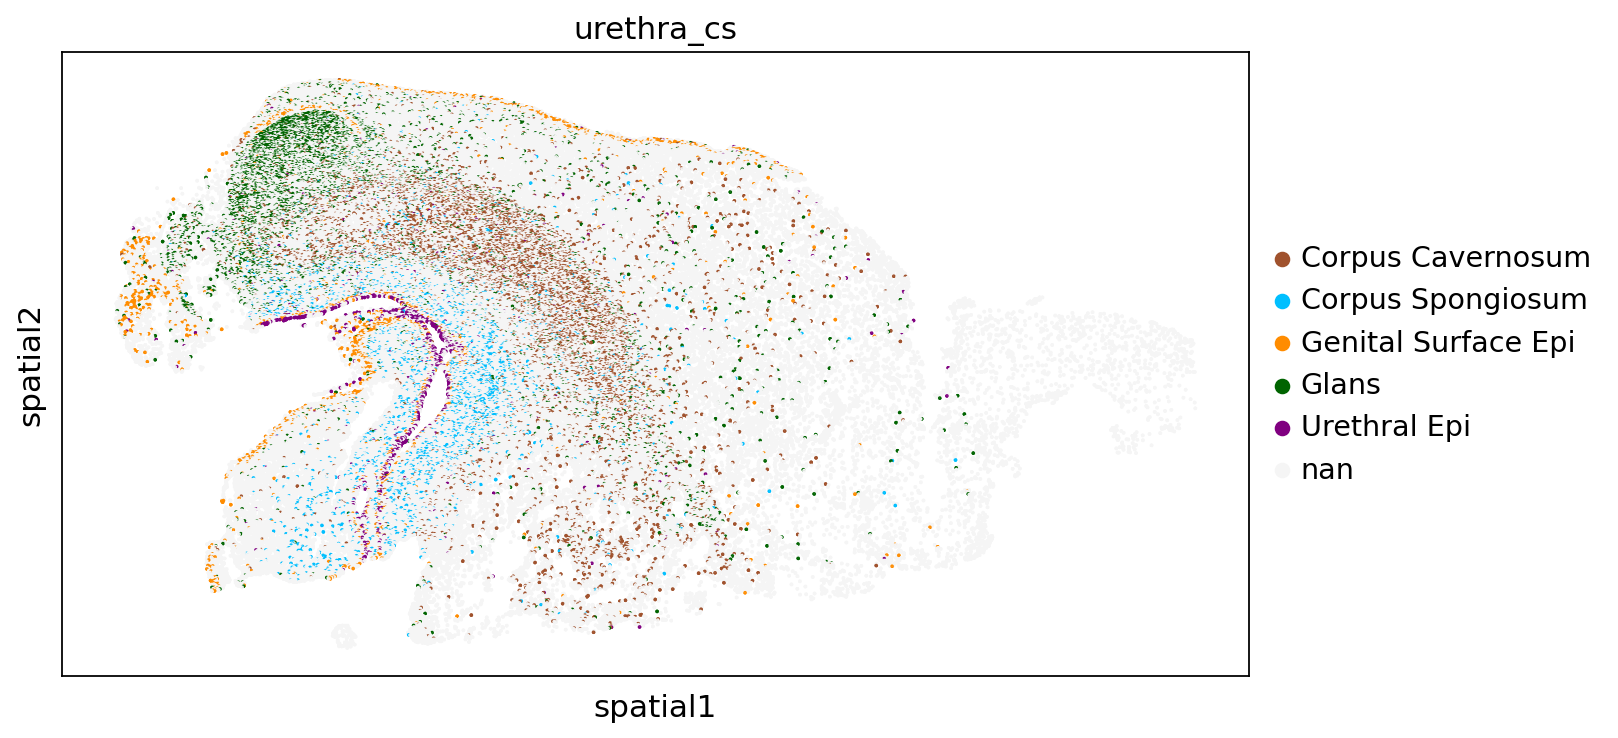

In [82]:
sq.pl.spatial_scatter(
    CM018,
    spatial_key="spatial",
    color=['urethra_cs'],
    shape=None,
    use_raw = False,
    size=1.5,
    cmap = 'jet',
    figsize=(10,10), 
#      legend_loc = 'right margin',
#                      palette= {'Corpus Spongiosum' : 'deepskyblue',  
#                                'Corpus Cavernosum' : 'sienna', 'Genital Surface Epi' : 'darkorange',
#                                'Glans' : 'darkgreen', 'Urethral Epi' : 'purple', 
         
#         'nan' : 'whitesmoke'
#                               },
    save = 'CM018_urethra_cs_filtered.pdf'
)

## Cell type enrichment in anatomical structures

In [28]:
out2 = out[[i >= 0.8 for i in out.obs['celltype_fraction']]]

In [29]:
out2.shape

(258797, 28078)

In [30]:
out2.obs['celltype'].value_counts()

Endothelial                 42413
Uterus/Cervix Epi           31210
Fallopian Epi               15440
Neural                      15060
Lower Vagina Epi            13343
Upper Vagina Mese           12918
Perivascular                12626
Lower Vagina SmMu           10881
Preputial Lamina Epi        10779
Immune                      10361
Schwann                      9587
Upper Vagina Epi             9534
Fallopian Mese               7244
Fallopian SmMu               5893
Glans                        5565
Coelomic Epi                 5390
Corpus Cavernosum            4605
Cervix/Upper Vagina SmMu     4117
Cervix/Vagina Lig            3713
Pre-Perivascular             3368
Bladder Mese                 3210
Endothelial Lymphatic        3118
Epoophron Mese               2644
Uterus SmMu                  2235
Uterus Mese                  2082
Urethral Epi                 1856
Mesonephric Tubules Epi      1855
Lower Vagina Mese            1669
Genital Surface Epi          1541
Uterus Lig    

In [31]:
out2.obs['broad_anatomy'].value_counts()

Cervix                   61854
FallopianTube            48060
UpperVagina              47375
Uterus                   39573
VaginalPlate             31669
External Genitalia       15351
Epoophron                 8046
LabioScrotal Swelling     3693
LowerTract                3176
Name: broad_anatomy, dtype: int64

In [32]:
out2.obs['broad_anatomy'] = np.where(out2.obs['broad_anatomy'].isin(['LowerTract', 'LabioScrotal Swelling', 
                                                                    'External Genitalia']), 
                                    'ExternalGenitalia', out2.obs['broad_anatomy'])

<ipython-input-32-b2bc0ab6f34c>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  out2.obs['broad_anatomy'] = np.where(out2.obs['broad_anatomy'].isin(['LowerTract', 'LabioScrotal Swelling',


In [33]:
df_subset = out2.obs[['celltype', 'broad_anatomy']]

In [47]:
# Creating pivot table
pivot_df = df_subset.pivot_table(index='broad_anatomy', columns='celltype', aggfunc='size', fill_value=0)

pivot_df

celltype           Bladder Mese  Cervix Mese  Cervix/Upper Vagina SmMu  \
broad_anatomy                                                            
Cervix                      171          320                      1958   
Epoophron                     4            5                        31   
ExternalGenitalia           656            2                        47   
FallopianTube                79           29                       241   
UpperVagina                1764           72                       892   
Uterus                       77           78                       531   
VaginalPlate                459            8                       417   

celltype           Cervix/Vagina Lig  Ciliated Epi  Coelomic Epi  \
broad_anatomy                                                      
Cervix                          1168             0          1032   
Epoophron                         82             0           446   
ExternalGenitalia                112             0           145   
FallopianTube                    260            15          1807   
UpperVagina                     1383             0           712   
Uterus                           162             1           974   
VaginalPlate                     546             0           274   

celltype           Corpus Cavernosum  Corpus Spongiosum  Endothelial  \
broad_anatomy                                                          
Cervix                           205                  1         9367   
Epoophron                         28                  0         1087   
ExternalGenitalia               3495                411         2851   
FallopianTube                    208                  0         9361   
UpperVagina                      350                  3         6200   
Uterus                            91                  1         9055   
VaginalPlate                     228                 39         4492   

celltype           Endothelial Lymphatic  ...  Preputial Lamina Epi  Schwann  \
broad_anatomy                             ...                                  
Cervix                               647  ...                  1247     2051   
Epoophron                            233  ...                   289      300   
ExternalGenitalia                    532  ...                  1902     1601   
FallopianTube                       1247  ...                  1370     1322   
UpperVagina                           98  ...                  2244     2004   
Uterus                               306  ...                  1088     1248   
VaginalPlate                          55  ...                  2639     1061   

celltype           Skeletal Muscle  Upper Vagina Epi  Upper Vagina Mese  \
broad_anatomy                                                             
Cervix                          14              1974                135   
Epoophron                        2                43                  5   
ExternalGenitalia               23                84                264   
FallopianTube                    6               316                 14   
UpperVagina                      4              5681               8149   
Uterus                           6              1062                 22   
VaginalPlate                     5               374               4329   

celltype           Urethral Epi  Uterus Lig  Uterus Mese  Uterus SmMu  \
broad_anatomy                                                           
Cervix                      201         209          635          686   
Epoophron                    67          10            1           21   
ExternalGenitalia           674          21           18           45   
FallopianTube               253         133           20          297   
UpperVagina                 284          39           17          231   
Uterus                      145         569         1388          826   
VaginalPlate                232          12            3          129   

celltype        

In [48]:
pivot_df.columns

Index(['Bladder Mese', 'Cervix Mese', 'Cervix/Upper Vagina SmMu',
       'Cervix/Vagina Lig', 'Ciliated Epi', 'Coelomic Epi',
       'Corpus Cavernosum', 'Corpus Spongiosum', 'Endothelial',
       'Endothelial Lymphatic', 'Epoophron Mese', 'Fallopian Epi',
       'Fallopian Lig', 'Fallopian Mese', 'Fallopian SmMu',
       'Genital Surface Epi', 'Glans', 'Immune', 'Labia', 'Lower Vagina Epi',
       'Lower Vagina Mese', 'Lower Vagina SmMu', 'Mesonephric Tubules Epi',
       'Neural', 'Perivascular', 'Pre-Perivascular', 'Prepuce',
       'Preputial Lamina Epi', 'Schwann', 'Skeletal Muscle',
       'Upper Vagina Epi', 'Upper Vagina Mese', 'Urethral Epi', 'Uterus Lig',
       'Uterus Mese', 'Uterus SmMu', 'Uterus/Cervix Epi'],
      dtype='object', name='celltype')

In [49]:
len(pivot_df.columns)

37

In [50]:
# Reorder columns
pivot_df = pivot_df[[
  'Fallopian Epi', 'Ciliated Epi', 'Fallopian Mese', 
                        'Fallopian Lig', 'Fallopian SmMu', 'Mesonephric Tubules Epi', 
                        'Epoophron Mese', 'Uterus/Cervix Epi', 'Uterus Mese', 
                        'Uterus Lig', 'Uterus SmMu', 'Cervix Mese', 'Cervix/Upper Vagina SmMu', 
                        'Cervix/Vagina Lig', 'Upper Vagina Epi', 'Upper Vagina Mese', 'Lower Vagina Epi',
                        'Lower Vagina Mese', 'Lower Vagina SmMu','Genital Surface Epi', 'Urethral Epi', 
                        'Preputial Lamina Epi', 'Glans', 'Corpus Spongiosum', 'Corpus Cavernosum', 'Prepuce'
                    ]]

In [51]:
pivot_df.index

Index(['Cervix', 'Epoophron', 'ExternalGenitalia', 'FallopianTube',
       'UpperVagina', 'Uterus', 'VaginalPlate'],
      dtype='object', name='broad_anatomy')

In [52]:
pivot_df = pivot_df.reindex(['FallopianTube', 'Epoophron', 'Uterus', 'Cervix',
                             'UpperVagina', 'VaginalPlate', 'ExternalGenitalia'])

In [53]:
pivot_df

celltype           Fallopian Epi  Ciliated Epi  Fallopian Mese  Fallopian Lig  \
broad_anatomy                                                                   
FallopianTube               8889            15            4496            440   
Epoophron                    100             0              49             44   
Uterus                      2540             1             772            212   
Cervix                      2334             0            1488            145   
UpperVagina                 1165             0             293             47   
VaginalPlate                 305             0              62             33   
ExternalGenitalia            107             0              84             18   

celltype           Fallopian SmMu  Mesonephric Tubules Epi  Epoophron Mese  \
broad_anatomy                                                                
FallopianTube                2611                      300            1149   
Epoophron                     145                     1294             953   
Uterus                       1026                       68             213   
Cervix                       1215                      143             148   
UpperVagina                   572                       33             101   
VaginalPlate                  246                       13              54   
ExternalGenitalia              78                        4              26   

celltype           Uterus/Cervix Epi  Uterus Mese  Uterus Lig  ...  \
broad_anatomy                                                  ...   
FallopianTube                    299           20         133  ...   
Epoophron                          2            1          10  ...   
Uterus                          7051         1388         569  ...   
Cervix                         21168          635         209  ...   
UpperVagina                     2640           17          39  ...   
VaginalPlate                      34            3          12  ...   
ExternalGenitalia                 16           18          21  ...   

celltype           Lower Vagina Epi  Lower Vagina Mese  Lower Vagina SmMu  \
broad_anatomy                                                               
FallopianTube                  1128                  4               1775   
Epoophron                       266                  5                221   
Uterus                          732                 20               2428   
Cervix                         1110                 26               2975   
UpperVagina                    1985                100               1107   
VaginalPlate                   7275               1062               1473   
ExternalGenitalia               847                452                902   

celltype           Genital Surface Epi  Urethral Epi  Preputial Lamina Epi  \
broad_anatomy                                                                
FallopianTube                      163           253                  1370   
Epoophron                           80            67                   289   
Uterus                              63           145                  1088   
Cervix                              47           201                  1247   
UpperVagina                        254           284                  2244   
VaginalPlate                       440           232                  2639   
ExternalGenitalia                  494           674                  1902   

celltype           Glans  Corpus Spongiosum  Corpus Cavernosum  Prepuce  
broad_anatomy                                                            
FallopianTube        129                  0                208       25  
Epoophron             35                  0                 28        2  
Uterus               516                  1                 91       77  
Cervix               830                  1                205       66  
UpperVagina          883                  3                350       46  
VaginalPlate         

In [54]:
# Compute the mean and standard deviation for each cell type
mean = pivot_df.mean()
std = pivot_df.std()

# Compute the Z-score for each cell type in each anatomical location
z_scores = (pivot_df - mean) / std


In [55]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [56]:
import seaborn as sns 

In [57]:
import matplotlib.pyplot as plt

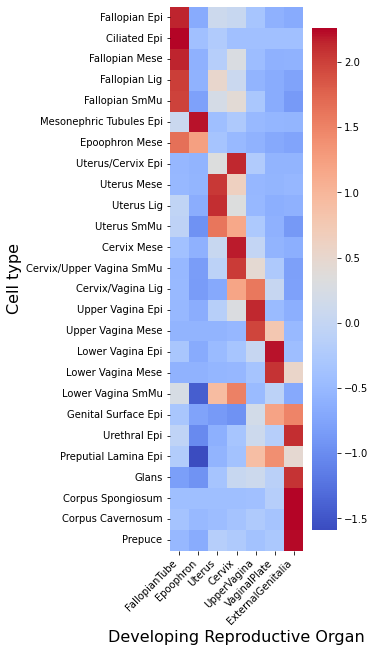

In [58]:
fig, ax = plt.subplots(figsize=(3, 10))         # Sample figsize in inches
g = sns.heatmap(z_scores.transpose(), cmap='coolwarm', #annot=True, 
            # fmt='.1f', 
            ax = ax)

g.set_xlabel('Developing Reproductive Organ', fontsize=16)
g.set_ylabel('Cell type', fontsize=16)
g.set_xticklabels(g.get_xticklabels(), rotation=45,  ha='right')

fig = g.get_figure()
fig.savefig("_ISS_femaleabove10pcw_abundance_per_anatomy.pdf", bbox_inches='tight')
plt.show()

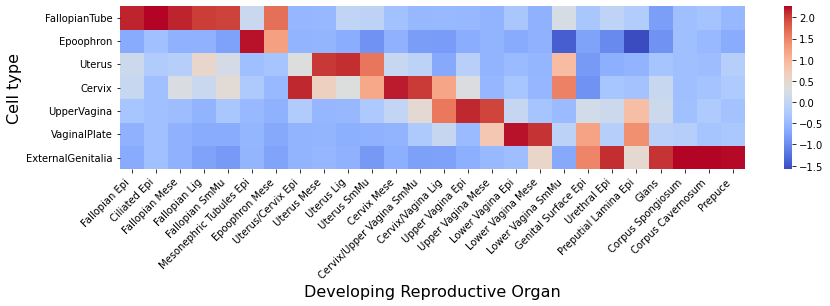

In [59]:
fig, ax = plt.subplots(figsize=(14, 3))         # Sample figsize in inches
g = sns.heatmap(z_scores, cmap='coolwarm', #annot=True, 
            # fmt='.1f', 
            ax = ax)

g.set_xlabel('Developing Reproductive Organ', fontsize=16)
g.set_ylabel('Cell type', fontsize=16)
g.set_xticklabels(g.get_xticklabels(), rotation=45,  ha='right')

fig = g.get_figure()
fig.savefig("_ISS_femaleabove10pcw_abundance_per_anatomy_horizontal.pdf", bbox_inches='tight')
plt.show()

## Read in Visium deconvolution and combine z-scores

In [60]:
visium_df = pd.read_csv('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/female_10xvisium_deconvolution.csv', 
                       index_col = 0)
visium_df.head()

Fallopian Epi  Ciliated Epi  Fallopian Mese  \
broad_anatomy_annots                                                
FallopianTube              2.266783      2.267025        2.263164   
Epoophron                 -0.372587     -0.391964       -0.390898   
Uterus                    -0.315558     -0.328155       -0.240447   
Cervix                    -0.380376     -0.358706       -0.371575   
UpperVagina               -0.399578     -0.397176       -0.419854   

                      Fallopian Lig  Fallopian SmMu  Mesonephric Tubules Epi  \
broad_anatomy_annots                                                           
FallopianTube              1.980465        2.159693                -0.220048   
Epoophron                 -0.542404       -0.569574                 2.246524   
Uterus                     0.638024        0.254571                -0.219120   
Cervix                    -0.048133       -0.198840                -0.279403   
UpperVagina               -0.629103       -0.567848                -0.525222   

                      Epoophron Mese  Uterus/Cervix Epi  Uterus Mese  \
broad_anatomy_annots                                                   
FallopianTube               0.787949          -0.503772    -0.505628   
Epoophron                   1.869660          -0.628106    -0.578847   
Uterus                     -0.024674           1.334349     1.892311   
Cervix                     -0.323495           1.582471     0.915592   
UpperVagina                -0.758874          -0.537295    -0.569375   

                      Uterus Lig  ...  Lower Vagina Epi  Lower Vagina Mese  \
broad_anatomy_annots              ...                                        
FallopianTube           1.210891  ...         -0.498765          -0.494833   
Epoophron              -0.617413  ...         -0.517541          -0.565332   
Uterus                  1.555061  ...         -0.491046          -0.416416   
Cervix                  0.119305  ...         -0.482276          -0.411803   
UpperVagina            -0.694253  ...         -0.138184          -0.493984   

                      Lower Vagina SmMu  Genital Surface Epi  Urethral Epi  \
broad_anatomy_annots                                                         
FallopianTube                  0.740893            -0.523556     -0.031107   
Epoophron                     -1.039171            -0.608820     -0.583041   
Uterus                         0.870714            -0.577275     -0.380018   
Cervix                         0.382799            -0.585497     -0.444106   
UpperVagina                   -1.186147            -0.556755     -0.603667   

                      Preputial Lamina Epi     Glans  Corpus Spongiosum  \
broad_anatomy_annots                                                      
FallopianTube                    -0.402412 -0.703633          -0.495253   
Epoophron                        -0.450801 -0.795013          -0.589307   
Uterus                           -0.404467 -0.642087          -0.406476   
Cervix                           -0.422347 -0.483331          -0.425019   
UpperVagina                      -0.347493  0.359369          -0.580714   

                      Corpus Cavernosum   Prepuce  
broad_anatomy_annots                               
FallopianTube                 -0.451754 -0.345839  
Epoophron                     -0.509514 -0.436087  
Uterus                        -0.444024 -0.328278  
Cervix                        -0.307789 -0.351367  
UpperVagina                   -0.181905 -0.429335  

[5 rows x 26 columns]

In [61]:
z_scores

celltype           Fallopian Epi  Ciliated Epi  Fallopian Mese  Fallopian Lig  \
broad_anatomy                                                                   
FallopianTube           2.143500      2.262793        2.144669       2.008290   
Epoophron              -0.675356     -0.406794       -0.610878      -0.591887   
Uterus                  0.107214     -0.228822       -0.162877       0.511218   
Cervix                  0.041145     -0.406794        0.280786       0.071289   
UpperVagina            -0.333784     -0.406794       -0.459686      -0.572189   
VaginalPlate           -0.609608     -0.406794       -0.602823      -0.664114   
ExternalGenitalia      -0.673111     -0.406794       -0.589191      -0.762606   

celltype           Fallopian SmMu  Mesonephric Tubules Epi  Epoophron Mese  \
broad_anatomy                                                                
FallopianTube            1.977969                 0.075215        1.650148   
Epoophron               -0.779113                 2.211320        1.230810   
Uterus                   0.205879                -0.423353       -0.352402   
Cervix                   0.417188                -0.262178       -0.491468   
UpperVagina             -0.301710                -0.498568       -0.592024   
VaginalPlate            -0.666191                -0.541548       -0.692579   
ExternalGenitalia       -0.854021                -0.560889       -0.752484   

celltype           Uterus/Cervix Epi  Uterus Mese  Uterus Lig  ...  \
broad_anatomy                                                  ...   
FallopianTube              -0.532790    -0.519437   -0.043700  ...   
Epoophron                  -0.570832    -0.555011   -0.650571  ...   
Uterus                      0.332058     2.041905    2.107484  ...   
Cervix                      2.140273     0.632044    0.331277  ...   
UpperVagina                -0.232937    -0.525054   -0.507488  ...   
VaginalPlate               -0.566733    -0.551266   -0.640703  ...   
ExternalGenitalia          -0.569039    -0.523181   -0.596298  ...   

celltype           Lower Vagina Epi  Lower Vagina Mese  Lower Vagina SmMu  \
broad_anatomy                                                               
FallopianTube             -0.320989          -0.590602           0.236018   
Epoophron                 -0.676569          -0.588083          -1.426811   
Uterus                    -0.484341          -0.550293           0.934749   
Cervix                    -0.328414          -0.535177           1.520057   
UpperVagina                0.032529          -0.348747          -0.478763   
VaginalPlate               2.214687           2.074845          -0.087131   
ExternalGenitalia         -0.436903           0.538056          -0.698119   

celltype           Genital Surface Epi  Urethral Epi  Preputial Lamina Epi  \
broad_anatomy                                                                
FallopianTube                -0.311386     -0.062487             -0.215762   
Epoophron                    -0.763673     -1.019643             -1.588907   
Uterus                       -0.856311     -0.618255             -0.573974   
Cervix                       -0.943499     -0.330079             -0.372003   
UpperVagina                   0.184496      0.097039              0.894441   
VaginalPlate                  1.198056     -0.170553              1.396192   
ExternalGenitalia             1.492316      2.103979              0.460014   

celltype              Glans  Corpus Spongiosum  Corpus Cavernosum   Prepuce  
broad_anatomy                                                                
FallopianTube     -0.821500          -0.424197          -0.358371 -0.510371  
Epoophron         -0.937447          -0.424197          -0.501765 -0.662537  
Uterus            -0.344142          -0.417671          -0.451577 -0.166343  
Cervix             0.043172          -0.417671          -0.360761 -0.239118  
UpperVagina        0.108547          -0.404618          -0.245249 -0.37

In [62]:
# Concatenate DataFrames vertically and then horizontally
combined_df = pd.concat([z_scores, visium_df], axis=0, sort=False).groupby(level=0).mean()

combined_df

Fallopian Epi  Ciliated Epi  Fallopian Mese  Fallopian Lig  \
Cervix                 -0.169616     -0.382750       -0.045394       0.011578   
Epoophron              -0.523972     -0.399379       -0.500888      -0.567145   
ExternalGenitalia      -0.535670     -0.400939       -0.504328      -0.731915   
FallopianTube           2.205142      2.264909        2.203916       1.994377   
UpperVagina            -0.366681     -0.401985       -0.439770      -0.600646   
Uterus                 -0.104172     -0.278488       -0.201662       0.574621   
VaginalPlate           -0.505031     -0.401367       -0.511874      -0.680870   

                   Fallopian SmMu  Mesonephric Tubules Epi  Epoophron Mese  \
Cervix                   0.109174                -0.270791       -0.407481   
Epoophron               -0.674343                 2.228922        1.550235   
ExternalGenitalia       -0.717338                -0.533210       -0.758528   
FallopianTube            2.068831                -0.072417        1.219049   
UpperVagina             -0.434779                -0.511895       -0.675449   
Uterus                   0.230225                -0.321237       -0.188538   
VaginalPlate            -0.581768                -0.519373       -0.739288   

                   Uterus/Cervix Epi  Uterus Mese  Uterus Lig  ...  \
Cervix                      1.861372     0.773818    0.225291  ...   
Epoophron                  -0.599469    -0.566929   -0.633992  ...   
ExternalGenitalia          -0.596574    -0.551661   -0.692840  ...   
FallopianTube              -0.518281    -0.512532    0.583595  ...   
UpperVagina                -0.385116    -0.547214   -0.600870  ...   
Uterus                      0.833204     1.967108    1.831273  ...   
VaginalPlate               -0.595136    -0.562589   -0.712456  ...   

                   Lower Vagina Epi  Lower Vagina Mese  Lower Vagina SmMu  \
Cervix                    -0.405345          -0.473490           0.951428   
Epoophron                 -0.597055          -0.576708          -1.232991   
ExternalGenitalia         -0.270320           0.363285          -0.795430   
FallopianTube             -0.409877          -0.542717           0.488456   
UpperVagina               -0.052827          -0.421366          -0.832455   
Uterus                    -0.487694          -0.483355           0.902731   
VaginalPlate               2.223118           2.134350           0.518261   

                   Genital Surface Epi  Urethral Epi  Preputial Lamina Epi  \
Cervix                       -0.764498     -0.387092             -0.397175   
Epoophron                    -0.686247     -0.801342             -1.019854   
ExternalGenitalia             1.264671      2.161252              1.361057   
FallopianTube                -0.417471     -0.046797             -0.309087   
UpperVagina                  -0.186129     -0.253314              0.273474   
Uterus                       -0.716793     -0.499137             -0.489220   
VaginalPlate                  1.506466     -0.173570              0.580806   

                      Glans  Corpus Spongiosum  Corpus Cavernosum   Prepuce  
Cervix            -0.220080          -0.421345          -0.334275 -0.295243  
Epoophron         -0.866230          -0.506752          -0.505639 -0.549312  
ExternalGenitalia  2.040724           2.201458           2.257264  2.250544  
FallopianTube     -0.762566          -0.459725          -0.405062 -0.428105  
UpperVagina        0.233958          -0.492666          -0.213577 -0.400386  
Uterus            -0.493114          -0.412074          -0.447800 -0.247310  
VaginalPlate       0.067309           0.091104          -0.350910 -0.330187  

[7 rows x 26 columns]

In [63]:
b = ['Fallopian Epi', 'Ciliated Epi', 'Fallopian Mese', 
                        'Fallopian Lig', 'Fallopian SmMu', 'Mesonephric Tubules Epi', 
                        'Epoophron Mese', 'Uterus/Cervix Epi', 'Uterus Mese', 
                        'Uterus Lig', 'Uterus SmMu', 'Cervix Mese', 'Cervix/Upper Vagina SmMu', 
                        'Cervix/Vagina Lig', 'Upper Vagina Epi', 'Upper Vagina Mese', 'Lower Vagina Epi',
                        'Lower Vagina Mese', 'Lower Vagina SmMu','Genital Surface Epi', 'Urethral Epi', 
                        'Preputial Lamina Epi', 'Glans', 'Corpus Spongiosum', 'Corpus Cavernosum', 'Prepuce']

In [64]:
a = ['FallopianTube', 'Epoophron', 'Uterus', 'Cervix',
                             'UpperVagina', 'VaginalPlate', 'ExternalGenitalia']

In [65]:
combined_df_reordered = combined_df.reindex(index=a, columns=b)

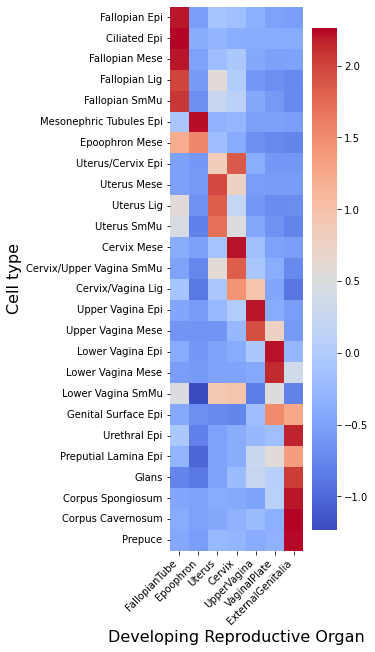

In [66]:
# Plot combined z-scores 
fig, ax = plt.subplots(figsize=(3, 10))         # Sample figsize in inches
g = sns.heatmap(combined_df_reordered.transpose(), cmap='coolwarm', #annot=True, 
            # fmt='.1f', 
            ax = ax)

g.set_xlabel('Developing Reproductive Organ', fontsize=16)
g.set_ylabel('Cell type', fontsize=16)
g.set_xticklabels(g.get_xticklabels(), rotation=45,  ha='right')

fig = g.get_figure()
fig.savefig("_ISS+VISIUM_femaleabove10pcw_abundance_per_anatomy.pdf", bbox_inches='tight')
plt.show()

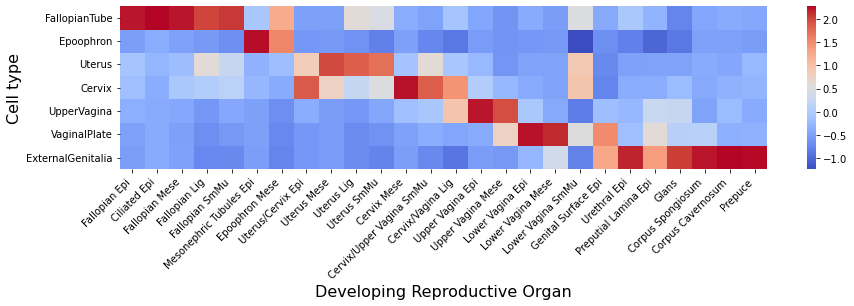

In [67]:
# Plot combined z-scores 
fig, ax = plt.subplots(figsize=(14.5, 3))         # Sample figsize in inches
g = sns.heatmap(combined_df_reordered, cmap='coolwarm', #annot=True, 
            # fmt='.1f', 
            ax = ax)

g.set_xlabel('Developing Reproductive Organ', fontsize=16)
g.set_ylabel('Cell type', fontsize=16)
g.set_xticklabels(g.get_xticklabels(), rotation=45,  ha='right')

fig = g.get_figure()
fig.savefig("_ISS+VISIUM_femaleabove10pcw_abundance_per_anatomy_horizontal.pdf", bbox_inches='tight')
plt.show()